In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import warnings

%matplotlib inline

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

In [2]:
warnings.filterwarnings('ignore')

## 1. Difference Dataset

In [3]:
# Reading in the data
df = pd.read_csv('Merged_Fundamentals_and_Polls/Remastered_df_10pred.csv')
df = df.drop(['Unnamed: 0'], axis = 1)

### 1.1. Preliminary EDA

In [4]:
display(df.describe())

,popular_vote_percentage,NAP,payroll,stock,rdi,election,national_polls,gdp,state_election,Democrat_Republican
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,47.888947,0.156816,0.080603,-6.943878,0.910273,0.033590,0.267359,0.093756,0.263158,0.500000
std,5.931859,0.292451,0.224088,14.691477,5.330156,0.053306,0.411531,0.065983,0.920758,0.506712
min,37.450000,-0.438399,-0.810255,-47.703968,-9.395652,-0.112869,-0.547339,-0.089281,-1.000000,0.000000
25%,43.647500,-0.023570,0.081262,-13.423767,-1.534151,0.031709,0.118346,0.066916,-1.000000,0.000000
50%,48.100000,0.160119,0.126141,-6.608670,0.577778,0.044007,0.185341,0.092272,1.000000,0.500000
75%,50.745000,0.290678,0.171749,-0.665031,3.717991,0.061724,0.333929,0.137343,1.000000,1.000000
max,61.050000,0.825641,0.261147,27.750394,13.389655,0.115117,1.700435,0.243113,1.000000,1.000000


The only two features that are not engineered in this DataFrame are **popular_vote_percentage** and **Democrat_Republican**.
- **popular_vote_percentage** - Shows the percentage of popular votes each presidentail candidate (Democrate or Republican) has won since 1948. As we observe from the data above, all the values seem reasonable, with $min = 37.45\%$ and $max = 61.05\%$. One thing worth poinitng out is that the mean of the **popular_vote_percentage** feature is not $\mu = 50\%$. This might seem confusing at first glance, but although the US political system is a two-party system, at each elections, there are some third-party or independent candidates that win some (usually) negligible vote percentage.
- **Democrat_Republican** - Shows if a presidential candidate is Democrat or Republican. As we expect, this feature is balanced, as exactly $50\%$ of the candidates are Democrats and the other $50\%$ are Republicans.


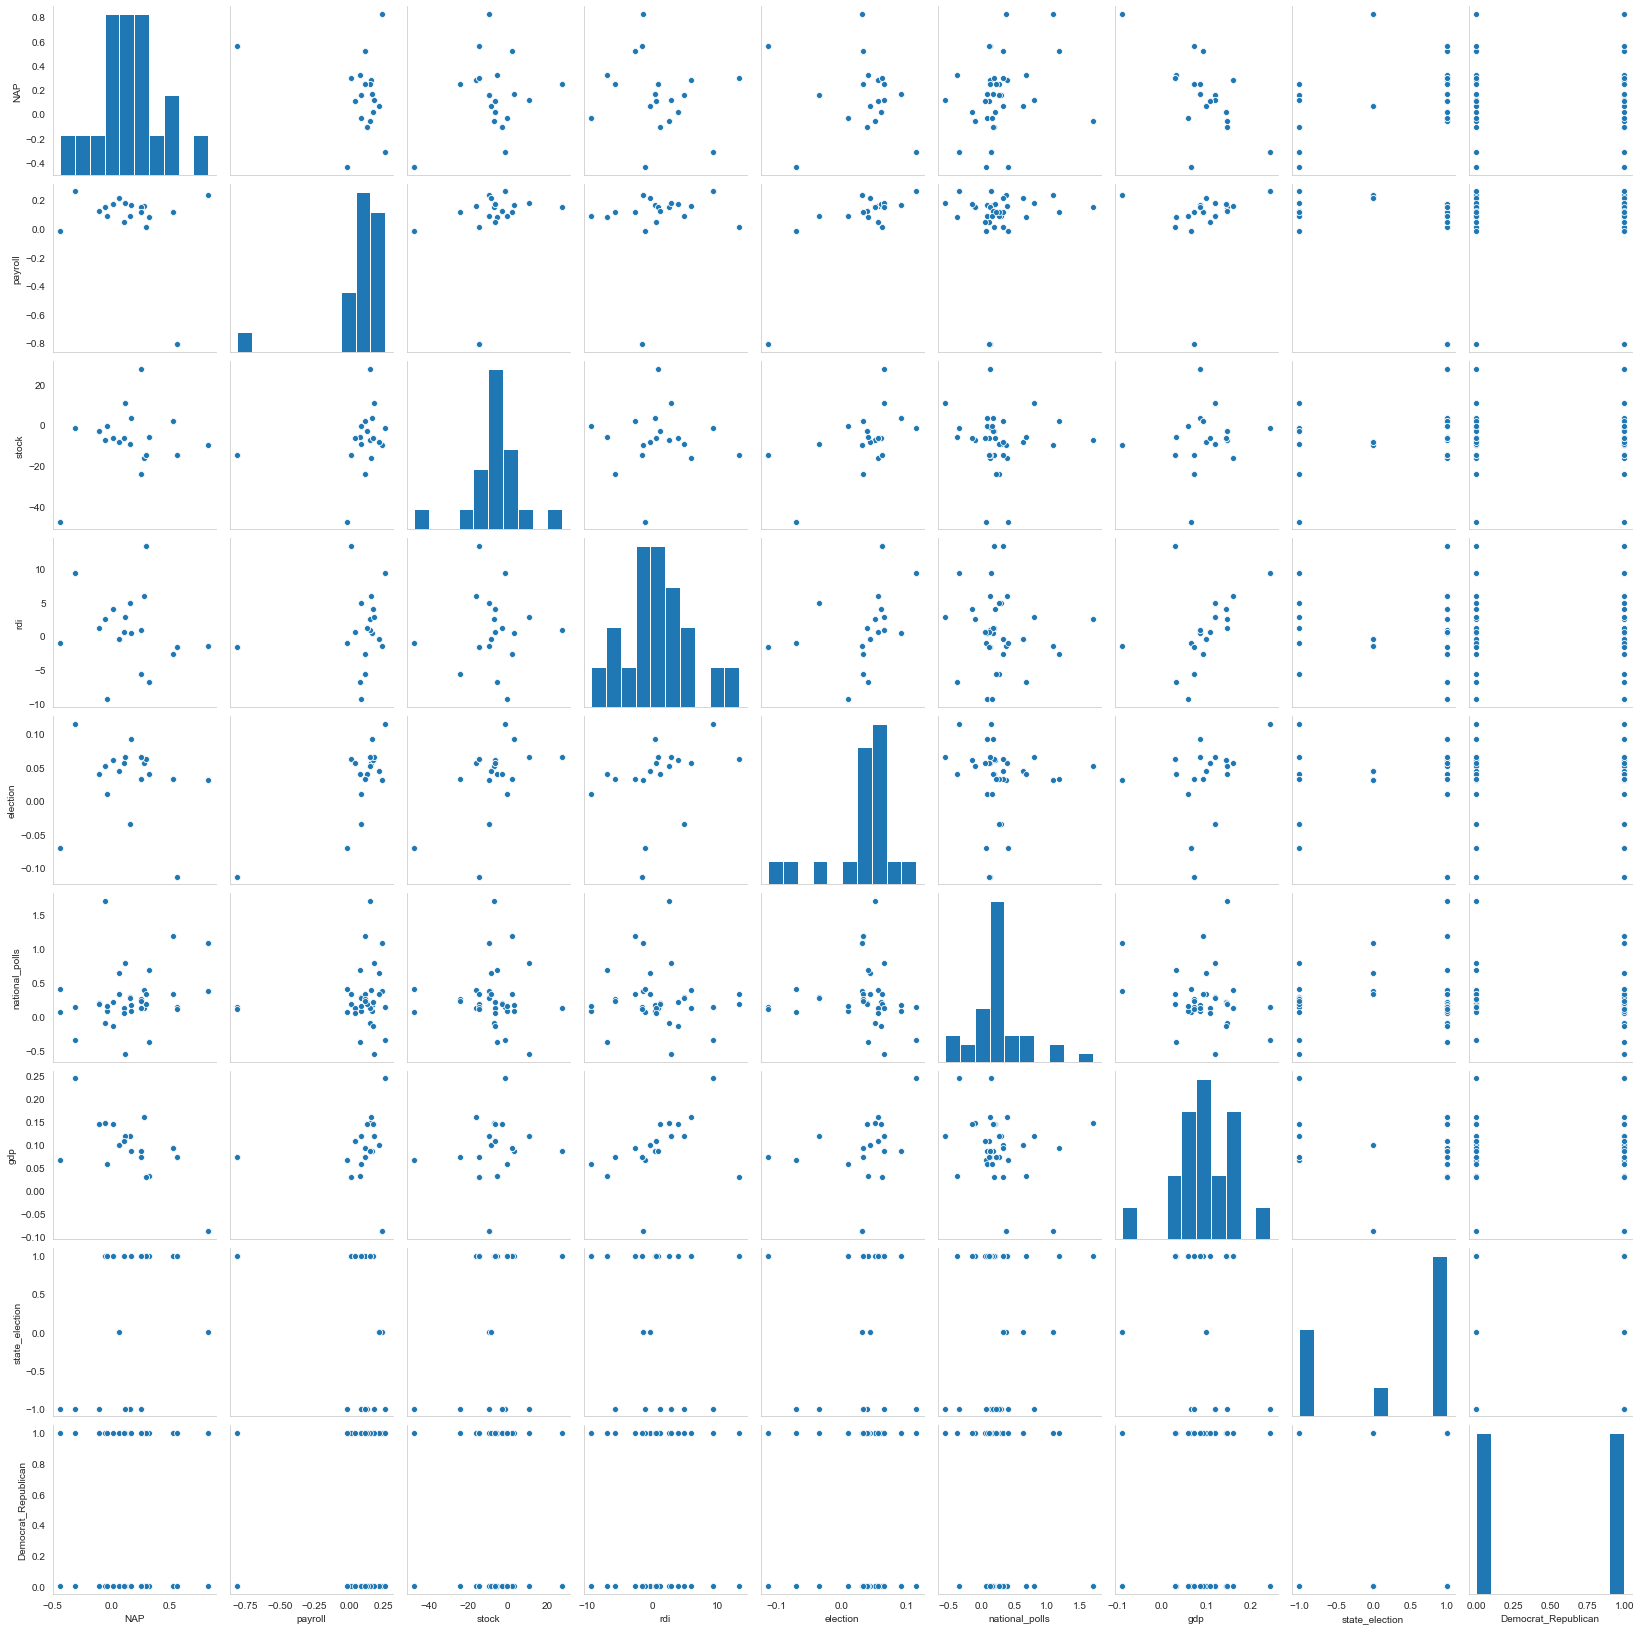

In [4]:
# Making a features pair-plot to investigate correlations between features
df_pair_plot = df.drop(['popular_vote_percentage'], axis = 1)

sns.set_style("whitegrid", {'axes.grid' : False})
sns.pairplot(df_pair_plot)

In [5]:
# Feature correlation matrix
correlation_df = pd.DataFrame(df_pair_plot.corr())
display(correlation_df)

,NAP,payroll,stock,rdi,election,national_polls,gdp,state_election,Democrat_Republican
NAP,1.000000,-0.260702,0.208599,-0.175240,-0.118891,0.245562,-0.634079,0.396063,0.000000
payroll,-0.260702,1.000000,0.260686,0.144824,0.764232,0.094932,0.154063,-0.217054,0.000000
stock,0.208599,0.260686,1.000000,0.025136,0.534316,-0.062951,0.159207,0.282587,0.000000
rdi,-0.175240,0.144824,0.025136,1.000000,0.338385,-0.082922,0.418721,-0.096106,0.000000
election,-0.118891,0.764232,0.534316,0.338385,1.000000,-0.055610,0.310715,0.109366,0.000000
national_polls,0.245562,0.094932,-0.062951,-0.082922,-0.055610,1.000000,-0.224071,0.079351,-0.131672
gdp,-0.634079,0.154063,0.159207,0.418721,0.310715,-0.224071,1.000000,-0.197311,0.000000
state_election,0.396063,-0.217054,0.282587,-0.096106,0.109366,0.079351,-0.197311,1.000000,0.000000
Democrat_Republican,0.000000,0.000000,0.000000,0.000000,0.000000,-0.131672,0.000000,0.000000,1.000000


The pair-plot above does not display any evident correlation between features. This might seem like a good thing at first glance but actually is rather worrisome, as it might mean that our data is not expessive enough for the problem at hand. In adition we elaborate on some instances where strong features correlation was expected by did not occur:
- Weak correlation between **NAP - natinal approval rating** and **national_polls - results from national polls**. A strogner correlation between these two features was expected as the national approval rating logically seems like a direct indicator of president's results in the national polls.
- Rather strong negative correlation between **NAP - national approval rating** and **gdp - gross domestic product** $(-0.634)$. This observation is also rather surprising as it seems like in the years with lower **gdp** president's had higher **NAP**.
- Negative correlation between **NAP - natinal approval rating** and **payroll**. This one seems pretty self explanatory, in years with higher **payroll** president's **NAP** seems to have been lower.

Now we are going to explore the distribution of the variables in the DataFrame. The intent is to look for potential outliers.

Note, for this part we exclude the **Democrat_Republican** feature, as it has only two possible values, and we already know its distribution.

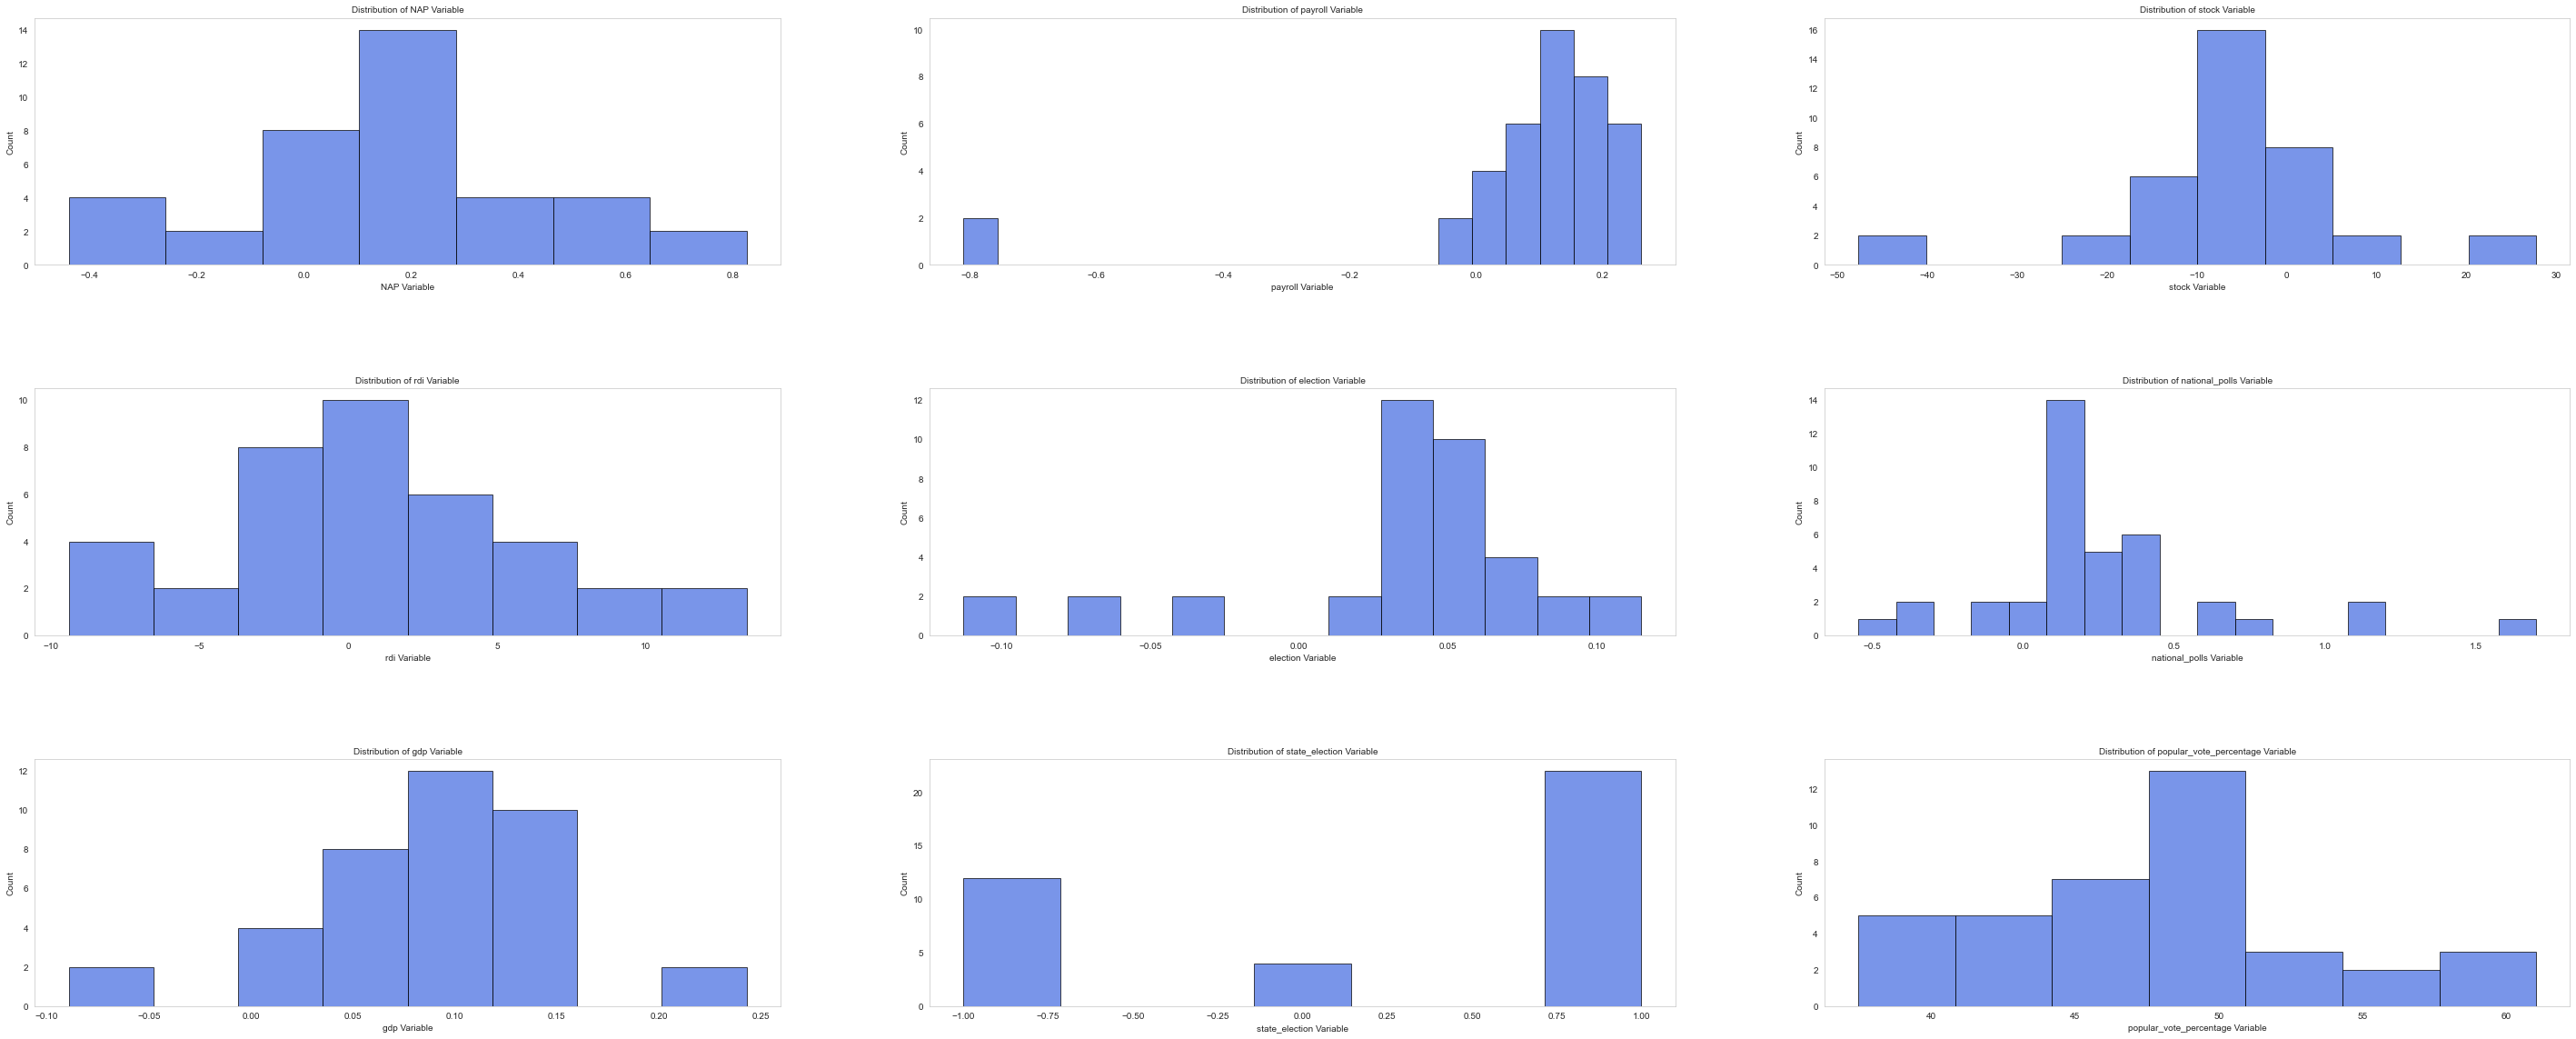

In [6]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(50, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.2)
axs = axs.ravel()
fontsize = 10

variables = ['NAP', 'payroll', 'stock', 'rdi', 'election', 'national_polls', 'gdp', 'state_election', 'popular_vote_percentage']

# Plot histograms
for i, variable in enumerate(variables):
    axs[i].hist(df[variable], alpha=0.7, color='royalblue', bins='auto', density=False, histtype = 'bar', edgecolor='k')
    axs[i].set_title("Distribution of " + variable + " Variable", fontsize=fontsize)
    axs[i].set_xlabel(variable + " Variable", fontsize=fontsize)
    axs[i].set_ylabel('Count', fontsize=fontsize)

All of the variables, except for **payroll** seem pretty reasonable, with a nice spread of the values. However, we do observe something weird in the **payroll** variable. There seems to be two "very" negative $-0.81$ observations, where all the other **payroll** observations are either positive or "slightly" negative. Let's explore further to see if these values outliers, or they have appeared due to some logical sequence of factors.

In [7]:
df.loc[(df['payroll']<=-0.8)]

,popular_vote_percentage,NAP,payroll,stock,rdi,election,national_polls,gdp,state_election,Democrat_Republican
36,47.4,0.55969,-0.810255,-14.658748,-1.571033,-0.112869,0.138836,0.071533,1.0,0
37,50.8,0.55969,-0.810255,-14.658748,-1.571033,-0.112869,0.116536,0.071533,1.0,1


From the data above, we observe that these two observation are from the 2020 elections. These values seems reasonable as there was an evident decline in the **payroll** as a result of the Covid-19 crisis. Therefore, we conclude that these values are not outliers and we continue further with our EDA.
Although it would be worth keeping this information in mind as the value of the **payroll** variable for the 2020 elections might highly influence our prediction of the *popular vote*.

### 1.2. Bootstrapped LassoCV to Assess Feature Importance

In [8]:
# Splitting into training and testing sets
X = df.drop(['popular_vote_percentage'], axis=1)
Y = df['popular_vote_percentage']
X_train = X.drop([36,37]).values
y_train = Y.drop([36,37]).values
X_test = X.iloc[[36,37]].values
y_test = Y.iloc[[36,37]].values
# Standardizing the features
X_1 = df.drop(['popular_vote_percentage', 'Democrat_Republican', 'state_election'], axis=1)
scaler = StandardScaler()
scaler.fit(X_1)
x_2 = scaler.transform(X_1)
X_2 = pd.DataFrame(x_2, columns = ['NAP', 'payroll','stock','rdi','election','national_polls','gdp'])
X_2['Democrat_Republican'] = df['Democrat_Republican']
X_2['state_election'] = df['state_election']
X_train1 = X_2.drop([36,37]).values
X_test1 = X_2.iloc[[36,37]].values

In [9]:
X_2_y = X_2.copy()
X_2_y['popular_vote_percentage'] = df['popular_vote_percentage']
X_2_y = X_2_y.drop([36,37])

In [10]:
# Function to generate bootstrapped DataFrames
def bootstrap(df):
    selectionIndex = np.random.randint(len(df), size = len(df))
    new_df = df.iloc[selectionIndex]
    return new_df

In [11]:
# Bootstrapped LassoCV
n_bootstraps = 100
coefs = []
intercepts = []
for n in range(n_bootstraps):
    df_new = bootstrap(X_2_y)
    #display(df_new)
    X_train_bootstrap = df_new.drop(['popular_vote_percentage'], axis = 1).values
    y_train_bootstrap = df_new['popular_vote_percentage'].values
    lassoCV = LassoCV(fit_intercept = True, cv = 5).fit(X_train_bootstrap, y_train_bootstrap)
    coefs.append(lassoCV.coef_)
    intercepts.append(lassoCV.intercept_)

In [13]:
# Re-formatting the coefficients lists for plotting 
coef1 = []
coef2 = []
coef3 = []
coef4 = []
coef5 = []
coef6 = []
coef7 = []
coef8 = []
coef9 = []
for coef in coefs:
    if float(coef[0]) >= 0.1:
        coef1.append(coef[0])
    else:
        coef1.append(0)
    if coef[1] >= 0.1:
        coef2.append(coef[1])
    else:
        coef2.append(0)
    if coef[2] >= 0.1:
        coef3.append(coef[2])
    else:
        coef3.append(0)
    if coef[3] >= 0.1:
        coef4.append(coef[3])
    else:
        coef4.append(0)
    if coef[4] >= 0.1:
        coef5.append(coef[4])
    else:
        coef5.append(0)
    if coef[5] >= 0.1:
        coef6.append(coef[5])
    else:
        coef6.append(0)
    if coef[6] >= 0.1:
        coef7.append(coef[6])
    else:
        coef7.append(0)
    if coef[7] >= 0.1:
        coef8.append(coef[7])
    else:
        coef8.append(0)
    if coef[8] >= 0.1:
        coef9.append(coef[8])
    else:
        coef9.append(0)
        
coefs = pd.DataFrame((coef1,coef2,coef3,coef4,coef5,coef6,coef7,coef8,coef9), index = ['coef1', 'coef2', 'coef3', 'coef4', 'coef5', 'coef6', 'coef7', 'coef8', 'coef9'])
coefs = coefs.T

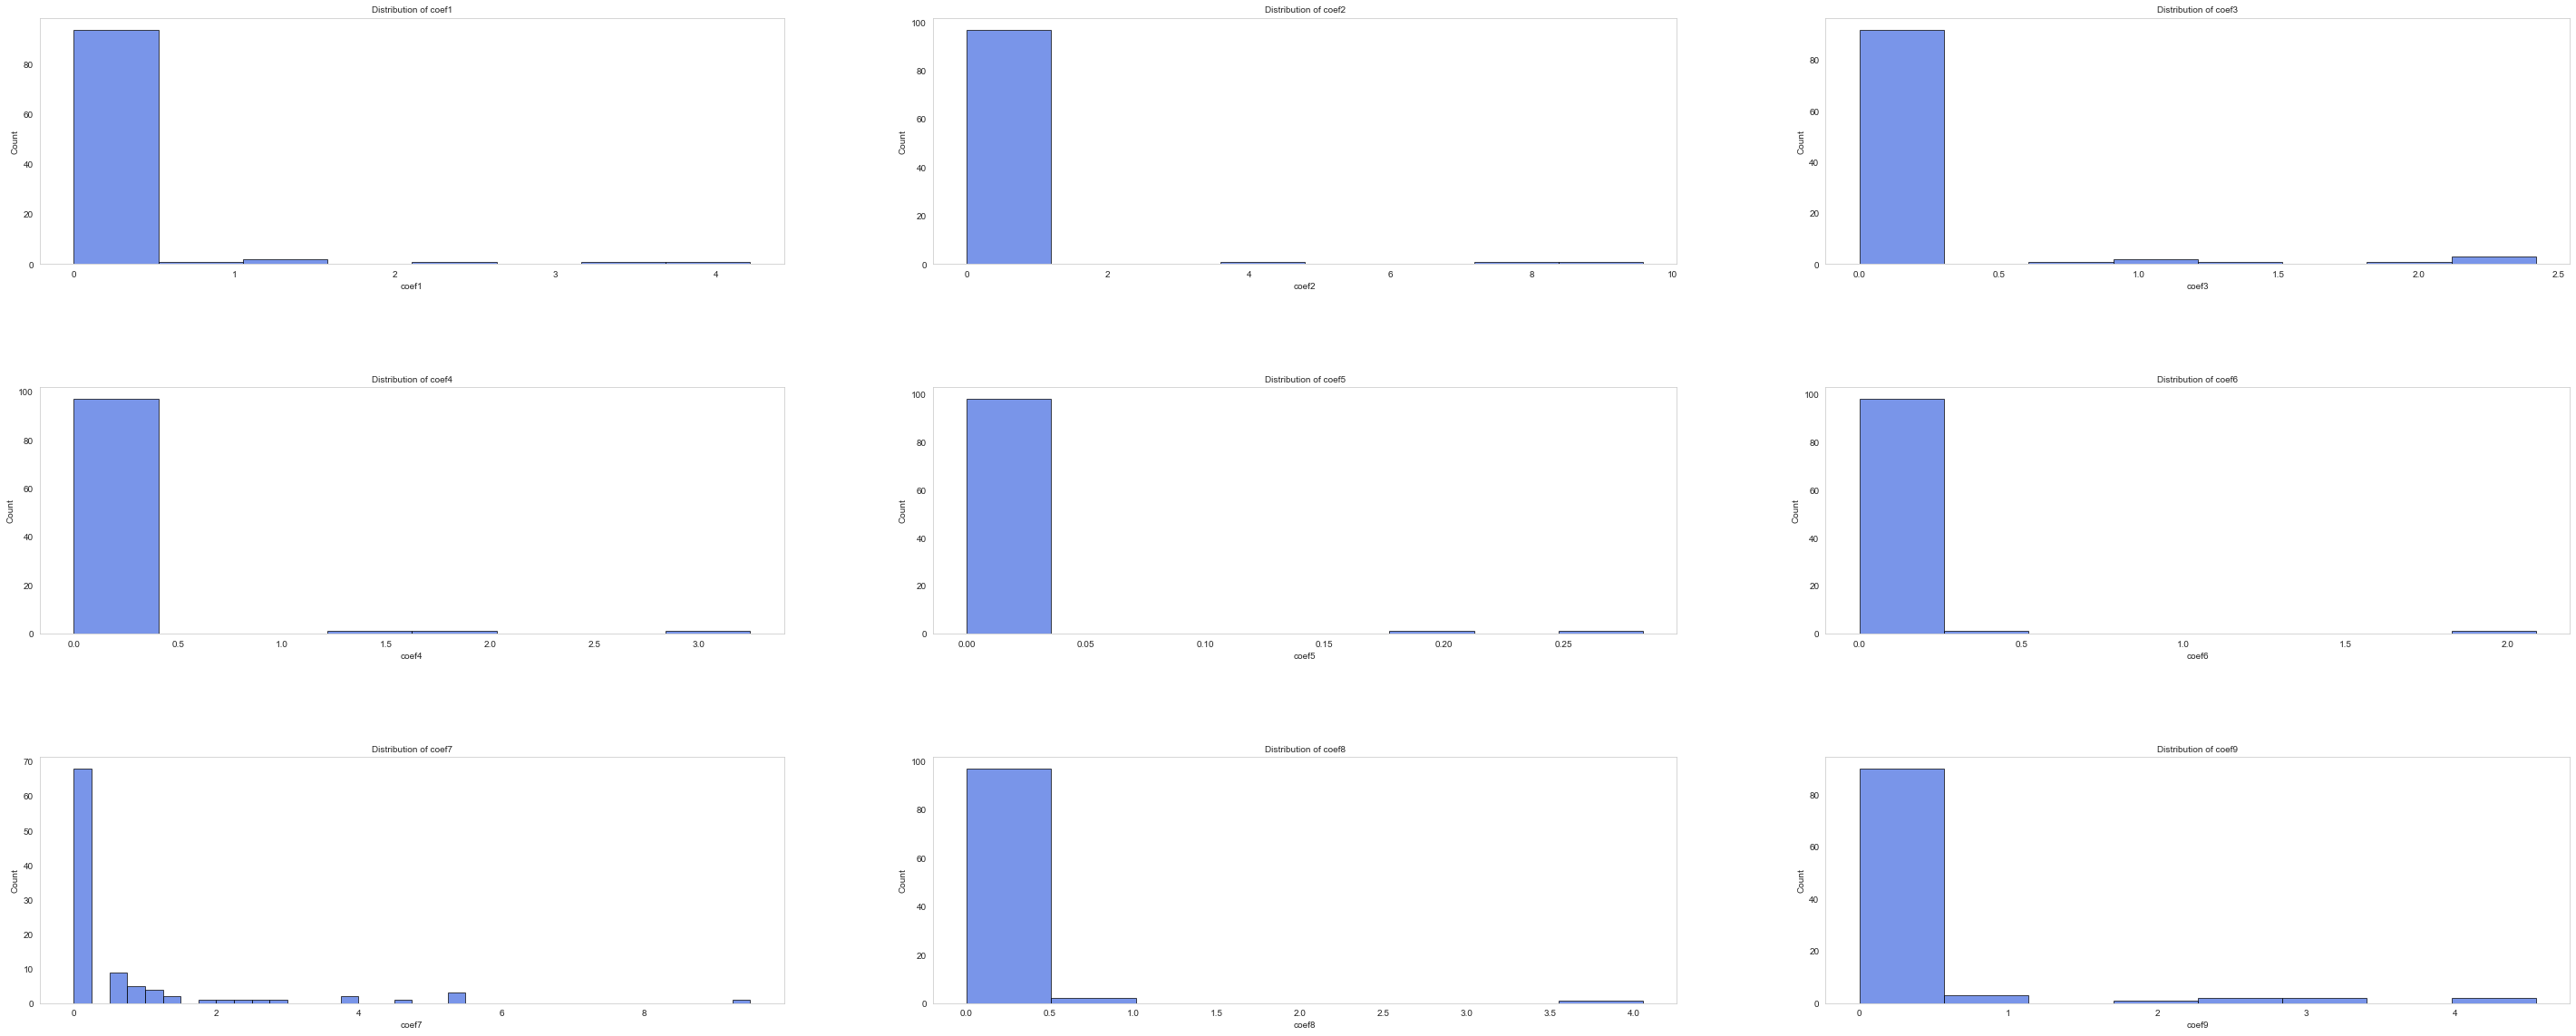

In [14]:
# Plotting histograms from bootstrapped LassoCV feature importance using 
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(50, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.2)
axs = axs.ravel()
fontsize = 10

variables = ['coef1', 'coef2', 'coef3', 'coef4', 'coef5', 'coef6', 'coef7', 'coef8', 'coef9']

# plot histograms
for i, variable in enumerate(variables):
    axs[i].hist(coefs[variable], alpha=0.7, color='royalblue', bins='auto', density=False, histtype = 'bar', edgecolor='k')
    axs[i].set_title("Distribution of " + variable, fontsize=fontsize)
    axs[i].set_xlabel(variable, fontsize=fontsize)
    axs[i].set_ylabel('Count', fontsize=fontsize)

**From the figure above, we observe that in most of the simulated bootstraps, the LassoCV model zeroes all feature's coefficients, i.e. the model learns that the mean prediction (intercept) is a better predictor than all of the features and therefore the features are not relevant for predicting the problem at hand. Consequently we decided no to proceed with the modeling phase on the difference dataset.**

## 2. Difference Sum Dataset

In [5]:
# Reading in the data
df_15 = pd.read_csv('Merged_Fundamentals_and_Polls/df_final_15_predictors.csv')

### 2.1. Bootstrapped LassoCV to Assess Feature Importance

In [16]:
# Splitting into training and testing sets
X = df_15.drop(['popular_vote_percentage'], axis=1)
Y = df_15['popular_vote_percentage']
X_train = X.drop([38,39]).values
y_train = Y.drop([38,39]).values
X_test = X.iloc[[38,39]].values
y_test = Y.iloc[[38,39]].values

In [17]:
# Standardizing the features
X_1 = df_15.drop(['popular_vote_percentage', 'Democrat_Republican', 'state_election'], axis=1)
scaler = StandardScaler()
scaler.fit(X_1)
x_2 = scaler.transform(X_1)
X_2 = pd.DataFrame(x_2, columns = ['NAP', 'payroll','stock','rdi','election','national_polls','gdp', 'NAP_weighted_diff', 'stock_weighted_diff', 'rdi_weighted_diff', 'national_polls_weighted_diff', 'gdp_weighted_diff'])
X_2['Democrat_Republican'] = df_15['Democrat_Republican']
X_2['state_election'] = df_15['state_election']
X_train1 = X_2.drop([38,39]).values
X_test1 = X_2.iloc[[38,39]].values

In [18]:
X_2_y = X_2.copy()
X_2_y['popular_vote_percentage'] = df_15['popular_vote_percentage']
X_2_y = X_2_y.drop([38,39])

In [19]:
# Function to generate bootstrapped DataFrames
def bootstrap(df):
    selectionIndex = np.random.randint(len(df), size = len(df))
    new_df = df.iloc[selectionIndex]
    return new_df

In [24]:
# Bootstrapped LassoCV
n_bootstraps = 100
coefs = []
intercepts = []
for n in range(n_bootstraps):
    df_new = bootstrap(X_2_y)
    #display(df_new)
    X_train_bootstrap = df_new.drop(['popular_vote_percentage'], axis = 1).values
    y_train_bootstrap = df_new['popular_vote_percentage'].values
    lassoCV = LassoCV(fit_intercept = True, cv = 5).fit(X_train_bootstrap, y_train_bootstrap)
    coefs.append(lassoCV.coef_)
    intercepts.append(lassoCV.intercept_)

In [26]:
# Re-formatting the coefficients lists for plotting 
coef1 = []
coef2 = []
coef3 = []
coef4 = []
coef5 = []
coef6 = []
coef7 = []
coef8 = []
coef9 = []
coef10 = []
coef11 = []
coef12 = []
coef13 = []
coef14 = []
for coef in coefs:
    if np.abs(float(coef[0])) >= 0.1:
        coef1.append(coef[0])
    else:
        coef1.append(0)
    if np.abs(coef[1]) >= 0.1:
        coef2.append(coef[1])
    else:
        coef2.append(0)
    if np.abs(coef[2]) >= 0.1:
        coef3.append(coef[2])
    else:
        coef3.append(0)
    if np.abs(coef[3]) >= 0.1:
        coef4.append(coef[3])
    else:
        coef4.append(0)
    if np.abs(coef[4]) >= 0.1:
        coef5.append(coef[4])
    else:
        coef5.append(0)
    if np.abs(coef[5]) >= 0.1:
        coef6.append(coef[5])
    else:
        coef6.append(0)
    if np.abs(coef[6]) >= 0.1:
        coef7.append(coef[6])
    else:
        coef7.append(0)
    if np.abs(coef[7]) >= 0.1:
        coef8.append(coef[7])
    else:
        coef8.append(0)
    if np.abs(coef[8]) >= 0.1:
        coef9.append(coef[8])
    else:
        coef9.append(0)
    if np.abs(coef[9]) >= 0.1:
        coef10.append(coef[9])
    else:
        coef10.append(0)
    if np.abs(coef[10]) >= 0.1:
        coef11.append(coef[10])
    else:
        coef11.append(0)
    if np.abs(coef[11]) >= 0.1:
        coef12.append(coef[11])
    else:
        coef12.append(0)
    if np.abs(coef[12]) >= 0.1:
        coef13.append(coef[12])
    else:
        coef13.append(0)
    if np.abs(coef[13]) >= 0.1:
        coef14.append(coef[13])
    else:
        coef14.append(0)

coefs = pd.DataFrame((coef1,coef2,coef3,coef4,coef5,coef6,coef7,coef8,coef9,coef10,coef11,coef12,coef13,coef14), index = ['NAP', 'payroll','stock','rdi','election','national_polls','gdp', 'NAP_weighted_diff', 'stock_weighted_diff', 'rdi_weighted_diff', 'national_polls_weighted_diff', 'gdp_weighted_diff', 'Democrat_Republican', 'state_election'])
coefs = coefs.T

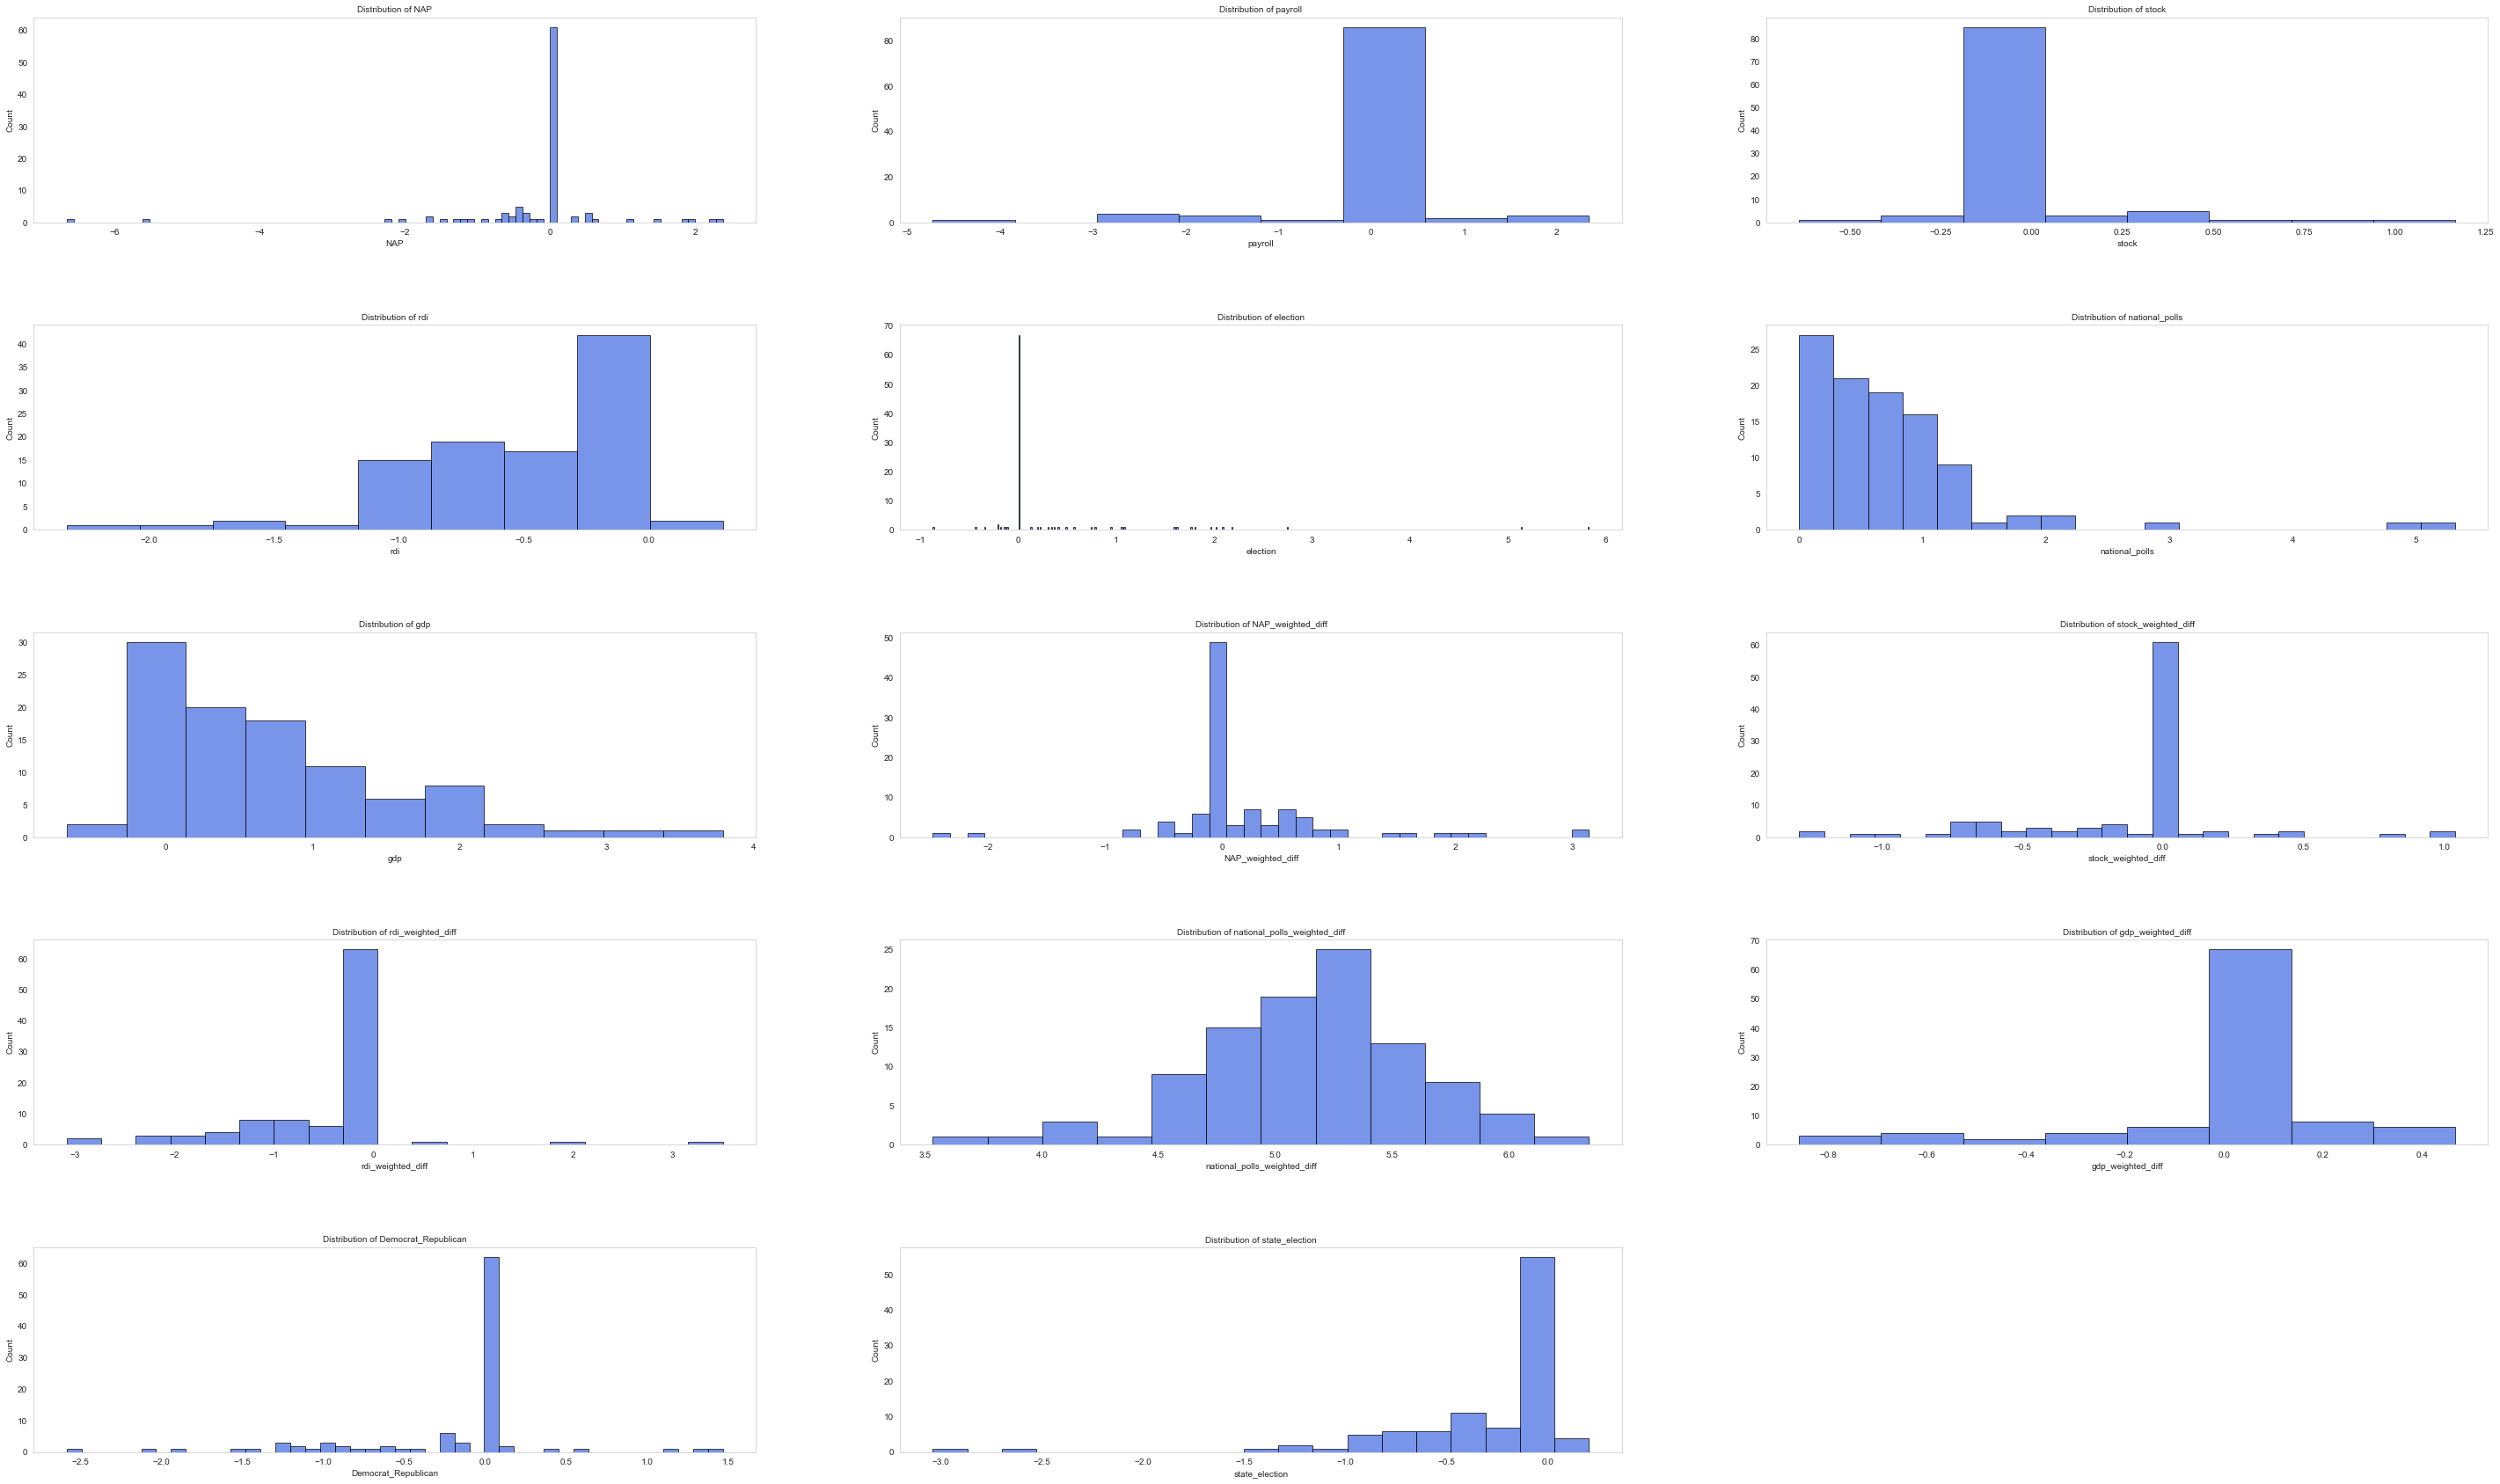

In [27]:
# Plotting histograms from bootstrapped LassoCV feature importance using 
plt.rcParams["axes.grid"] = False
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(50, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.2)
axs = axs.ravel()
fontsize = 10

variables = ['NAP', 'payroll','stock','rdi','election','national_polls','gdp', 'NAP_weighted_diff', 'stock_weighted_diff', 'rdi_weighted_diff', 'national_polls_weighted_diff', 'gdp_weighted_diff', 'Democrat_Republican', 'state_election']

# plot histograms
for i, variable in enumerate(variables):
    axs[i].hist(coefs[variable], alpha=0.7, color='royalblue', bins='auto', density=False, histtype = 'bar', edgecolor='k')
    axs[i].set_title("Distribution of " + variable, fontsize=fontsize)
    axs[i].set_xlabel(variable, fontsize=fontsize)
    axs[i].set_ylabel('Count', fontsize=fontsize)
    
axs[14].set_axis_off()

**In the difference/sum data set, we observed that in the majority of bootstrapped samples the values of the coefficients were zeroed (Figure above). Although we observe that some features, such as ‘rdi’, ‘national_polls’ and ‘national_polls_dif’ are somewhat adequate for modeling the ‘popular vote_percentage’, after performing the baseline modeling on the difference/sum dataset (not shown here for brevity) to further reinforce out beliefs, we decided not to include this dataset as our final dataset for predicting the popular vote.**

## 3. Initial Dataset

In [6]:
# Reading in the data
df_final = pd.read_csv('Merged_Fundamentals_and_Polls/merged_df_final.csv')
df_final = df_final.drop(['Unnamed: 0', 'President_winning', 'Date', 'Year', 'Name', 'Winner', 'popular_votes', 'El_winner'], axis = 1)

### 3.1. Preliminary EDA

In [30]:
display(df_final.describe())

,NAP06,NAP07,NAP08,NAP09,NAP10,Current_President_Seeking_Reelection,Early_Stopping_Previous,2nd_Mandate_Prev_Pres,Year0,Year1,Year2,Electiony1,Electiony2,Electiony3,Electiony4,payroll_y1,payroll_y2,payroll_y3,payroll_ey1,payroll_ey2,payroll_ey3,rdi_y0,rdi_y1,rdi_y2,rdi_ey,Stock_y1,Stock_y2,Stock_y3,Stock_ey,Month_10,Month_11,Month_6,Month_7,Month_8,Month_9,Democrat_Republican,popular_vote_percentage
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,36.000000,38.000000,38.000000,36.000000,38.000000,38.000000,38.000000
mean,0.476316,0.494211,0.496316,0.508421,0.513158,0.578947,0.052632,0.315789,8393.428526,8608.174684,8870.478632,8919.543526,8896.277632,9001.719842,8987.985053,91971.315789,93500.368421,95101.473684,95955.000000,96120.000000,95250.789474,2.589474,3.263158,2.857895,3.768421,0.077884,0.052779,0.154474,0.044121,44.875674,46.022017,43.971017,44.355577,44.391720,44.741576,0.500000,47.888947
std,0.106756,0.121180,0.121709,0.119289,0.127303,0.500355,0.226294,0.471069,5228.840970,5378.938206,5488.196844,5457.749853,5321.617596,5441.611022,5333.556355,35406.349112,35508.577755,35671.671823,34779.708983,34791.291476,33688.733471,2.028418,2.386496,2.104902,1.745435,0.167451,0.182105,0.109601,0.128840,7.393428,6.905157,10.015712,7.514228,7.730693,7.627277,0.506712,5.931859
min,0.320000,0.300000,0.290000,0.310000,0.270000,0.000000,0.000000,0.000000,2102.251000,2068.901000,2055.103000,2086.017000,2120.450000,2132.598000,2134.981000,38600.000000,43093.000000,44411.000000,45178.000000,45294.000000,45245.000000,-1.300000,-1.100000,-4.100000,0.700000,-0.172700,-0.275700,-0.022300,-0.338400,29.000000,33.385331,19.000000,28.500000,29.000000,28.153888,0.000000,37.450000
25%,0.397500,0.402500,0.382500,0.407500,0.417500,0.000000,0.000000,0.000000,3654.534000,3814.064500,3982.847000,4066.022750,4117.144000,4172.040500,4185.946000,56321.250000,58244.250000,59518.500000,61046.750000,61298.250000,61275.000000,1.625000,2.000000,2.225000,2.750000,-0.086975,-0.075125,0.056750,-0.033150,41.110080,41.584805,39.006240,41.004892,40.291699,39.795630,0.000000,43.647500
50%,0.480000,0.510000,0.500000,0.520000,0.530000,1.000000,0.000000,0.000000,6902.105000,6802.497000,7339.893000,7483.371000,7612.668000,7686.059000,7749.151000,91380.000000,88907.000000,91520.000000,95032.000000,95344.000000,95629.000000,2.900000,3.600000,3.300000,3.500000,0.128800,0.048200,0.164000,0.042700,45.439953,45.990625,44.240800,43.617280,45.493182,45.168537,0.500000,48.100000
75%,0.527500,0.580000,0.597500,0.590000,0.580000,1.000000,0.000000,1.000000,12889.492500,13241.024000,13828.632000,13896.905000,14037.352750,14143.342750,14272.533500,128516.000000,129707.250000,130384.750000,132156.750000,132288.000000,129987.750000,3.475000,4.575000,4.100000,4.800000,0.244700,0.172950,0.219475,0.142825,49.448651,49.566256,48.045203,47.934388,48.123622,48.311509,1.000000,50.745000
max,0.690000,0.700000,0.720000,0.740000,0.760000,1.000000,1.000000,1.000000,18359.432000,18813.923000,19253.959000,19010.848000,17668.203000,18583.984000,17876.179000,147196.000000,149549.000000,151553.000000,144647.000000,144916.000000,145061.000000,6.200000,9.200000,6.700000,7.100000,0.276600,0.439600,0.383200,0.260100,64.000000,64.000000,76.500000,61.000000,65.000000,63.500000,1.000000,61.050000


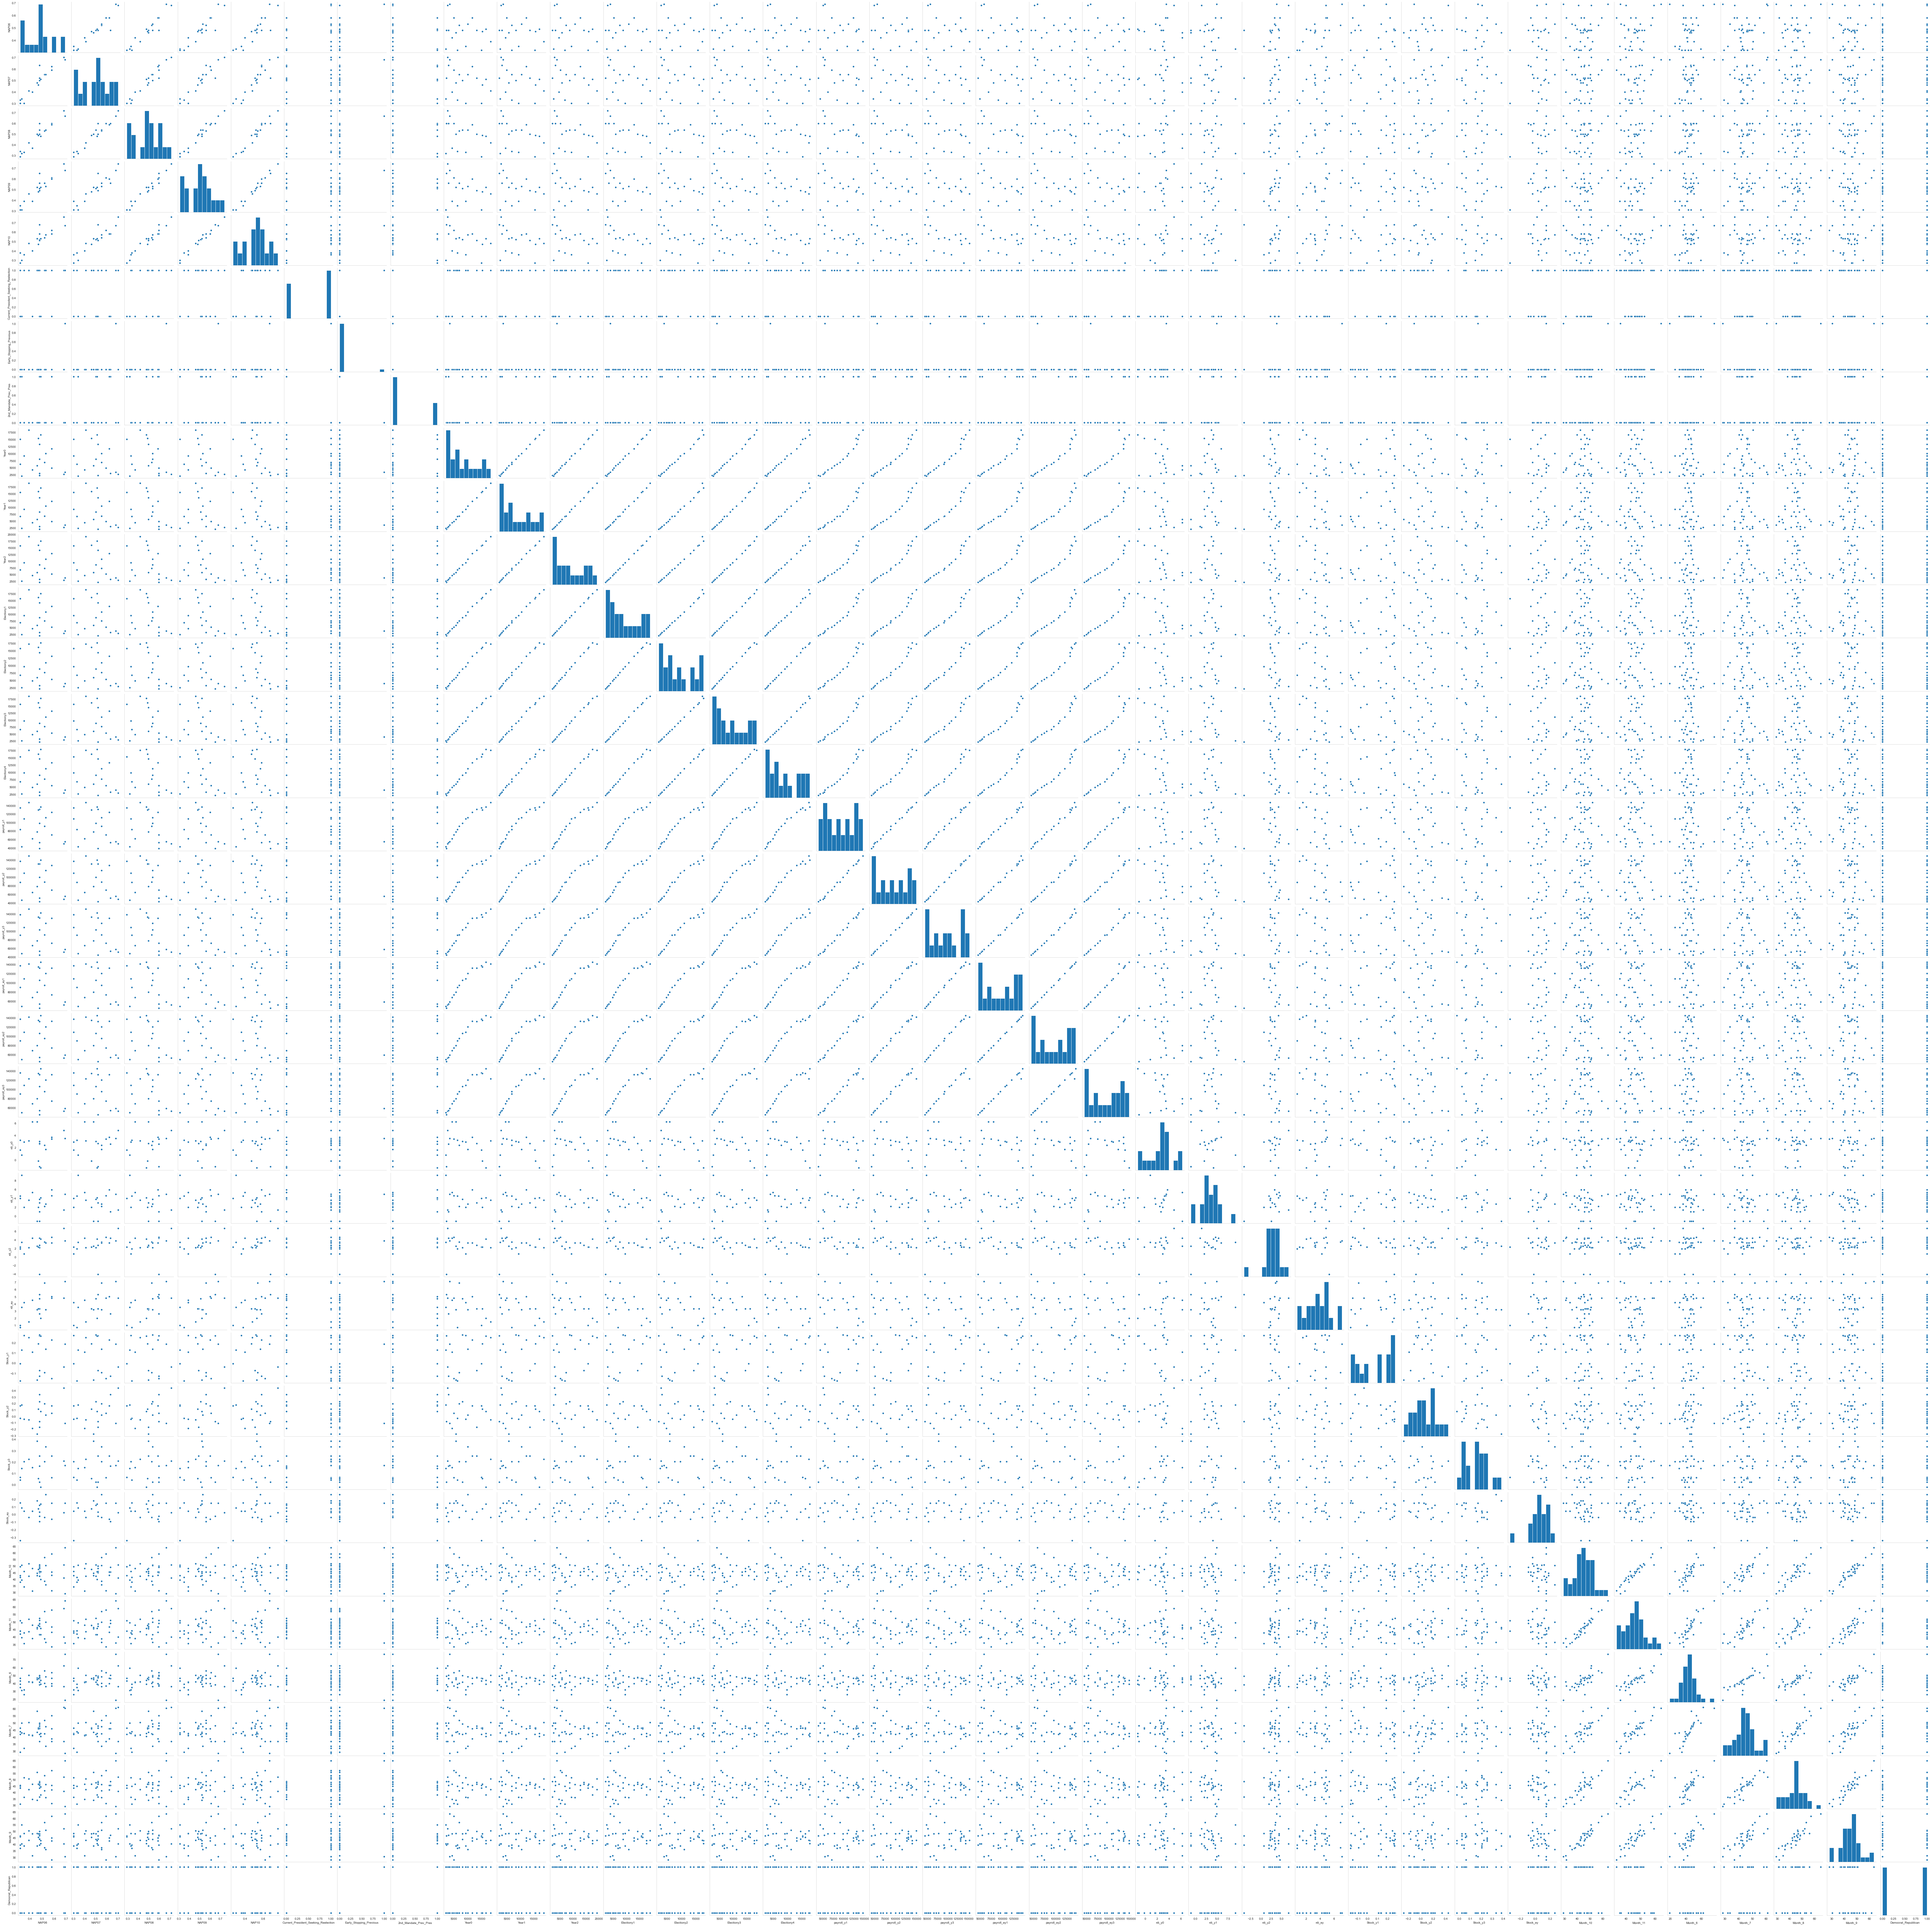

In [31]:
# Making a features pair-plot to investigate correlations between features
df_pair_plot = df_final.drop(['popular_vote_percentage'], axis = 1)

sns.set_style("whitegrid", {'axes.grid' : False})
sns.pairplot(df_pair_plot)

**Zooming in on the correlated features.**

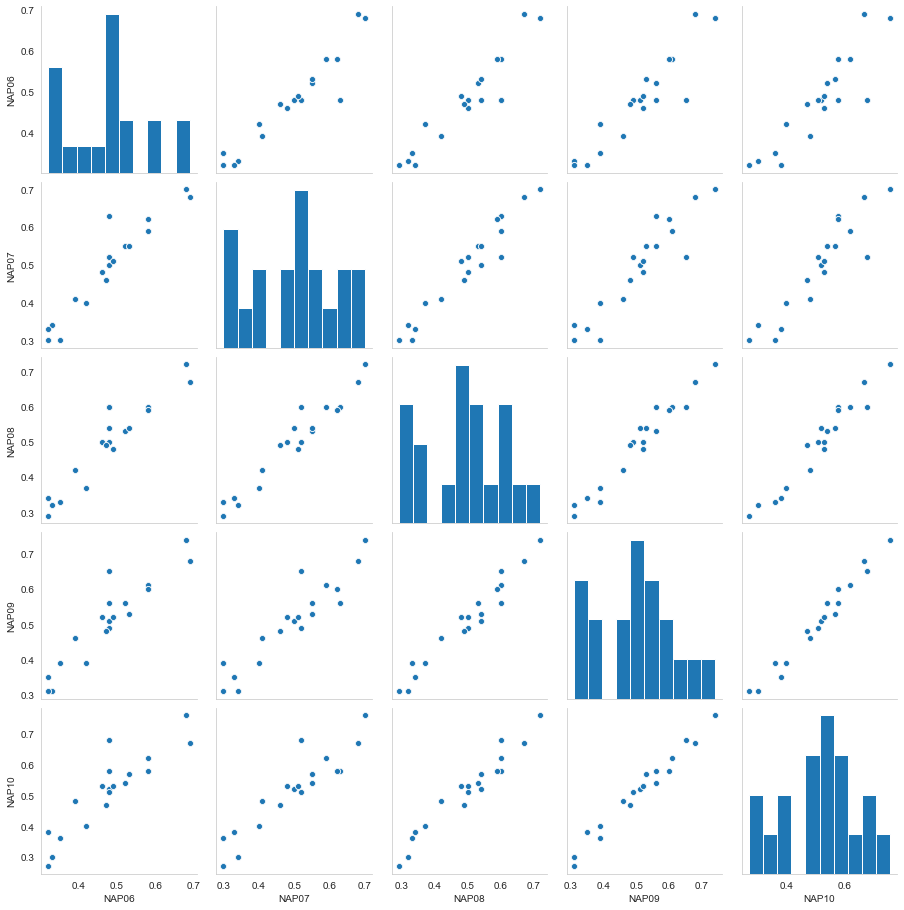

In [32]:
df_pair_plot = df_final[['NAP06', 'NAP07', 'NAP08', 'NAP09', 'NAP10']]

sns.set_style("whitegrid", {'axes.grid' : False})
sns.pairplot(df_pair_plot)

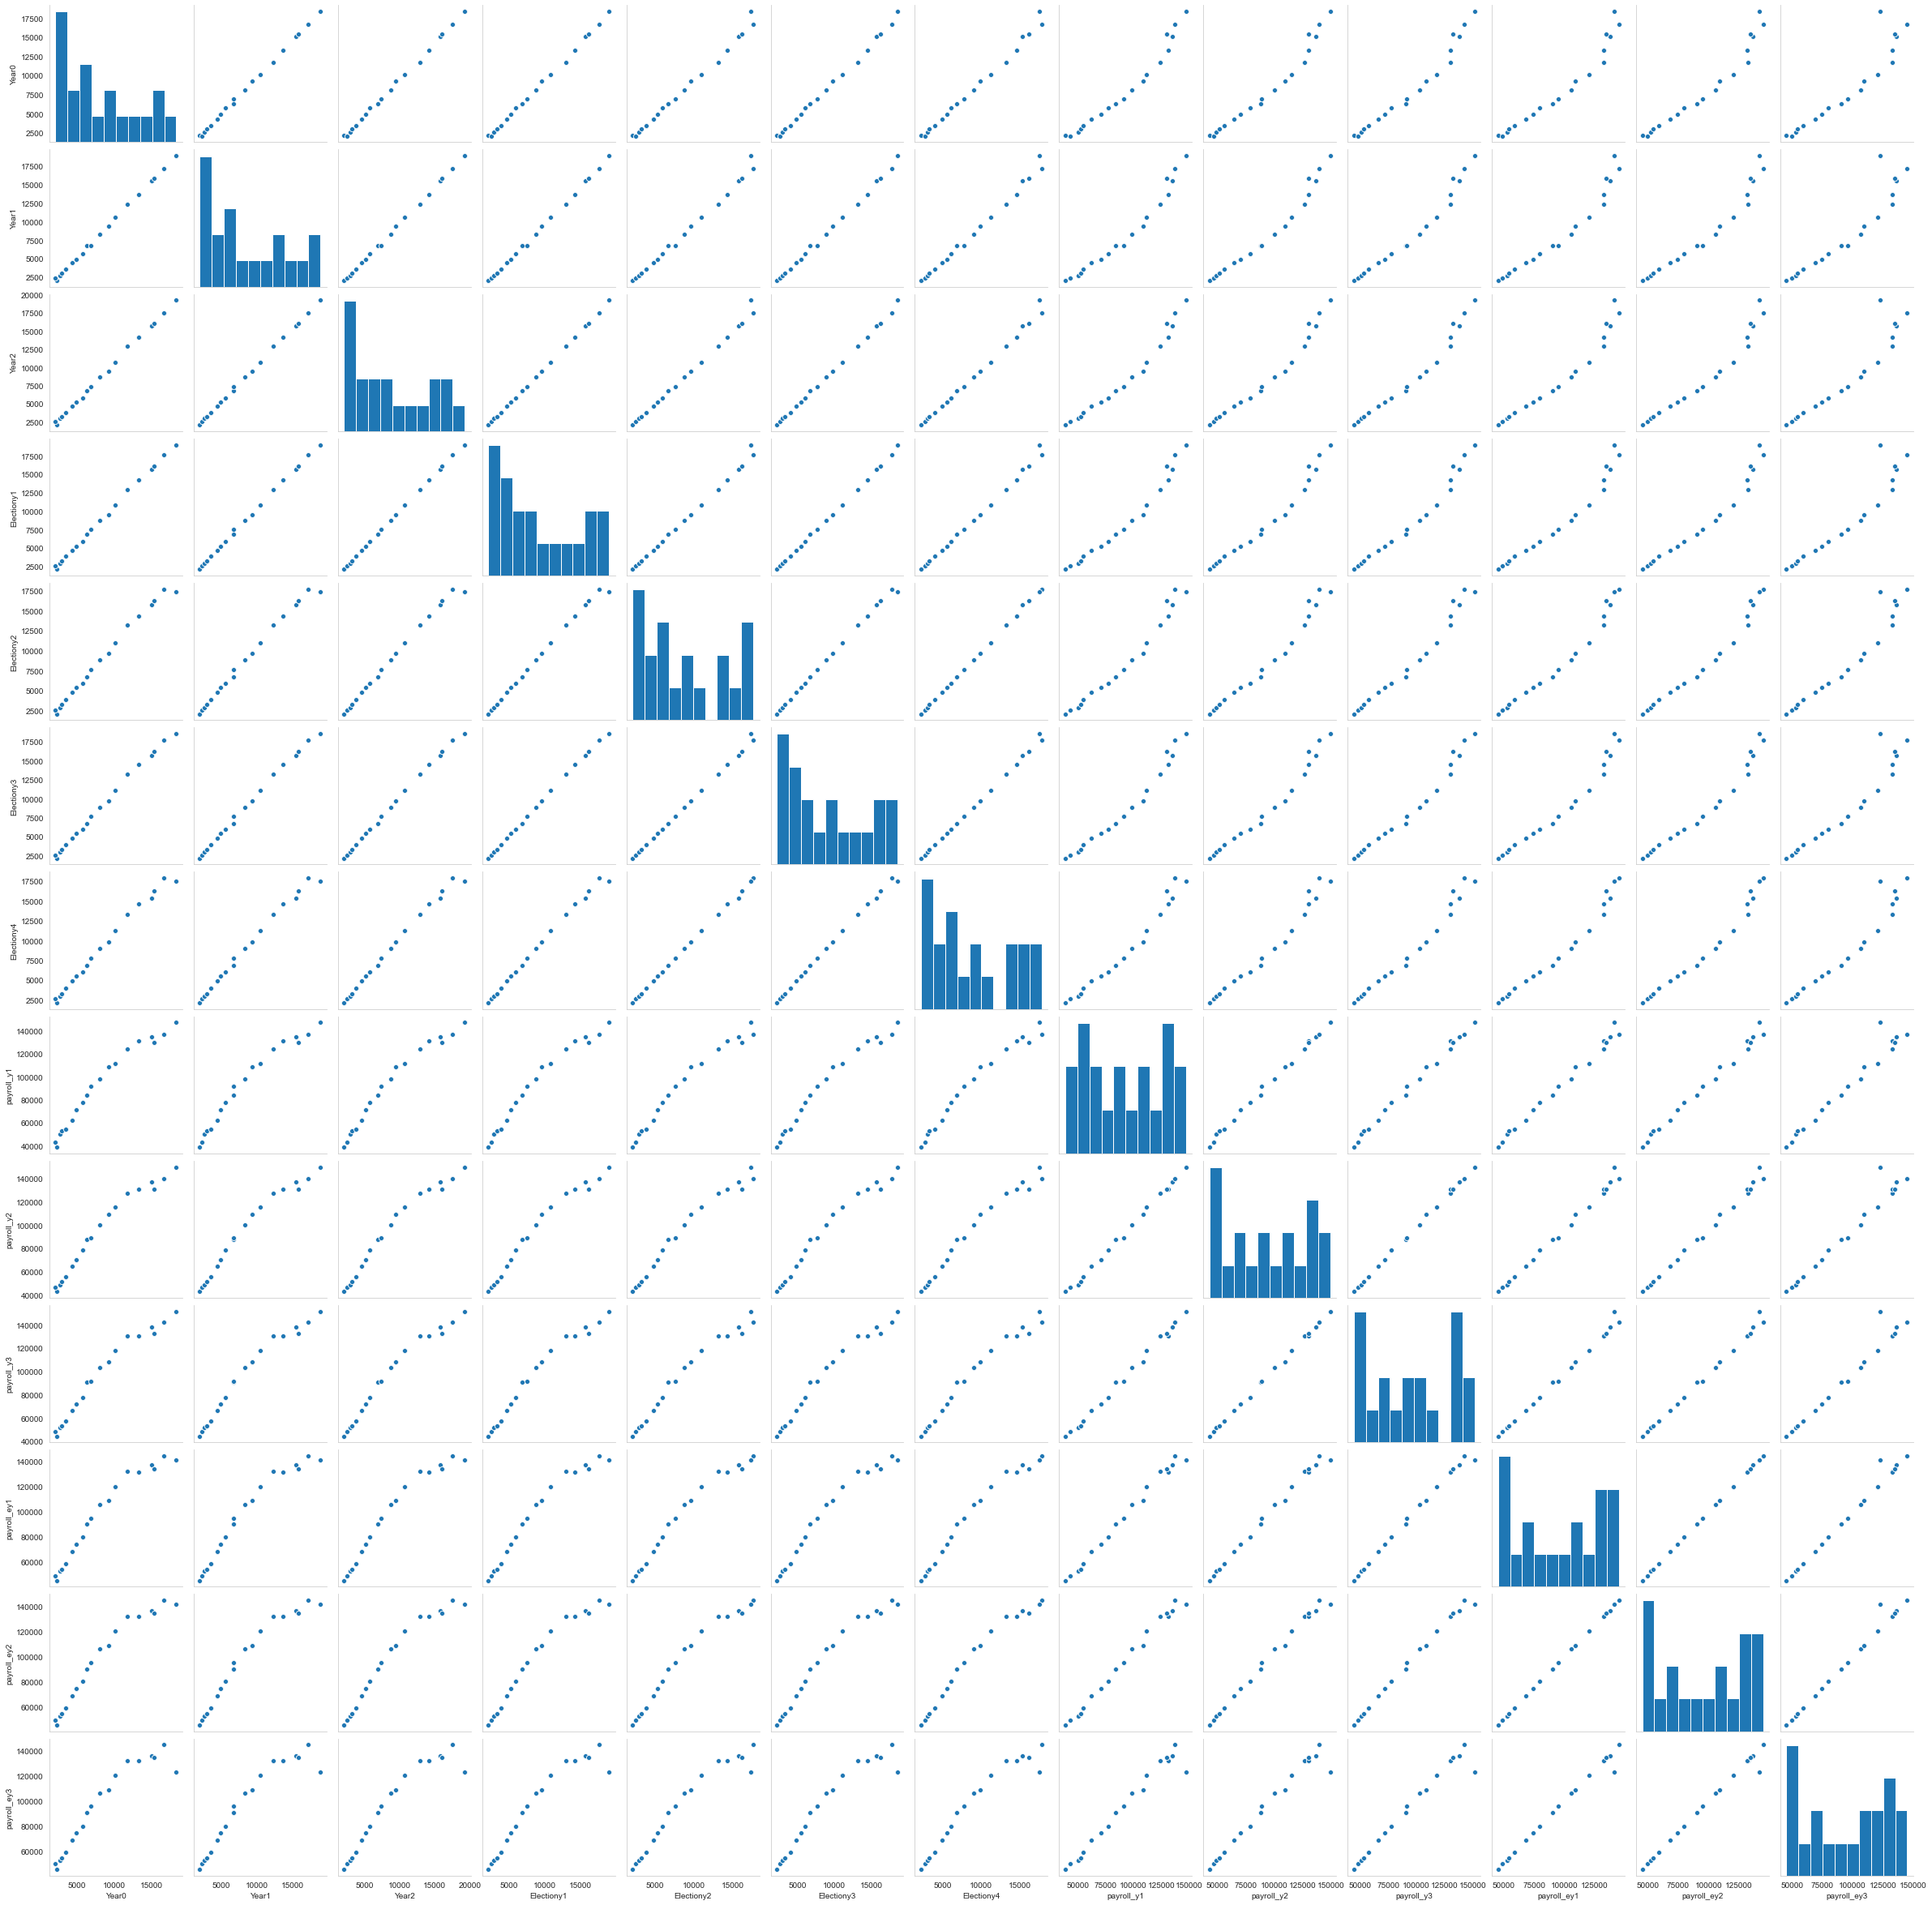

In [33]:
df_pair_plot = df_final[['Year0', 'Year1', 'Year2', 'Electiony1', 'Electiony2', 'Electiony3', 'Electiony4', 'payroll_y1', 'payroll_y2', 'payroll_y3', 'payroll_ey1', 'payroll_ey2', 'payroll_ey3']]

sns.set_style("whitegrid", {'axes.grid' : False})
sns.pairplot(df_pair_plot)

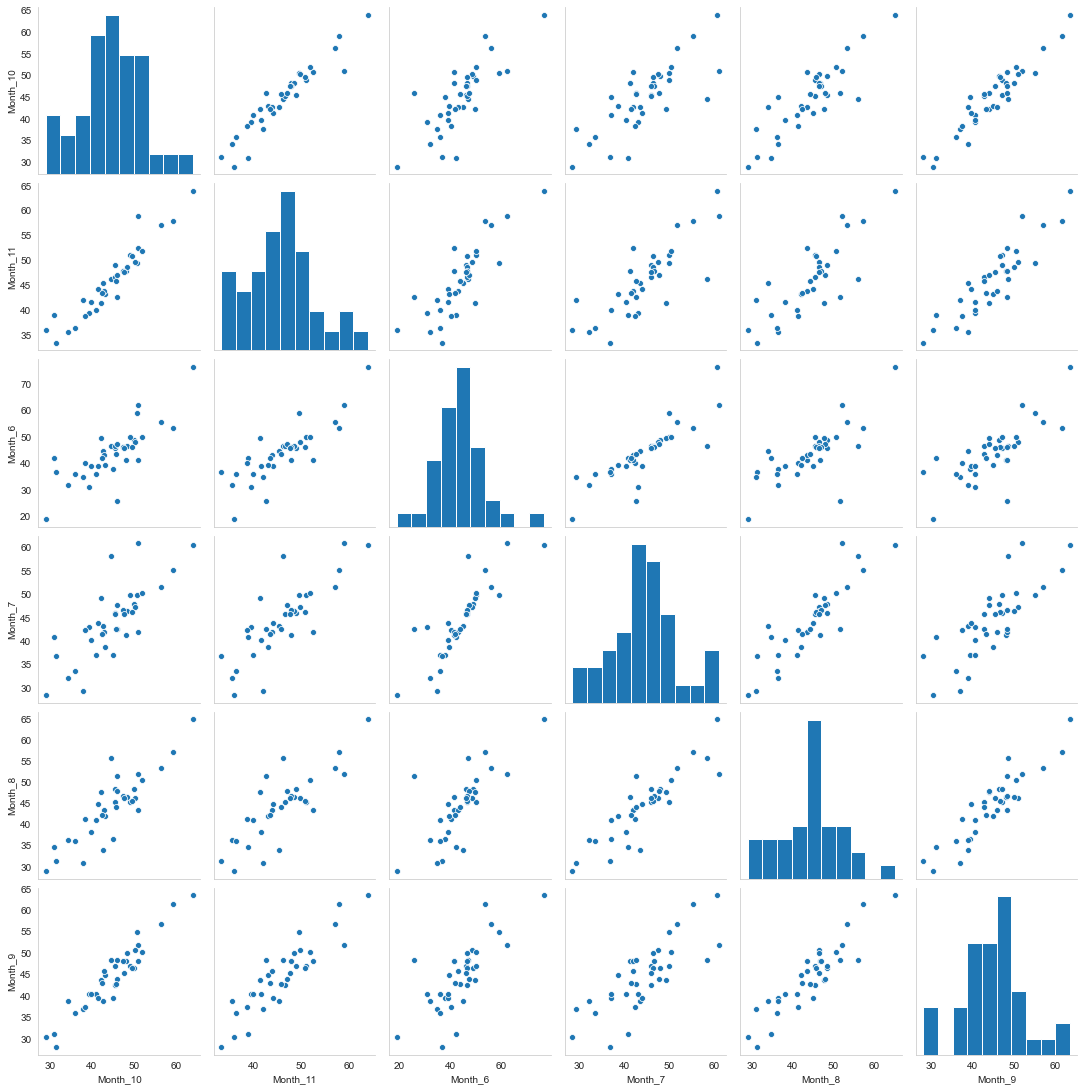

In [34]:
df_pair_plot = df_final[['Month_10', 'Month_11', 'Month_6', 'Month_7', 'Month_8', 'Month_9']]

sns.set_style("whitegrid", {'axes.grid' : False})
sns.pairplot(df_pair_plot)

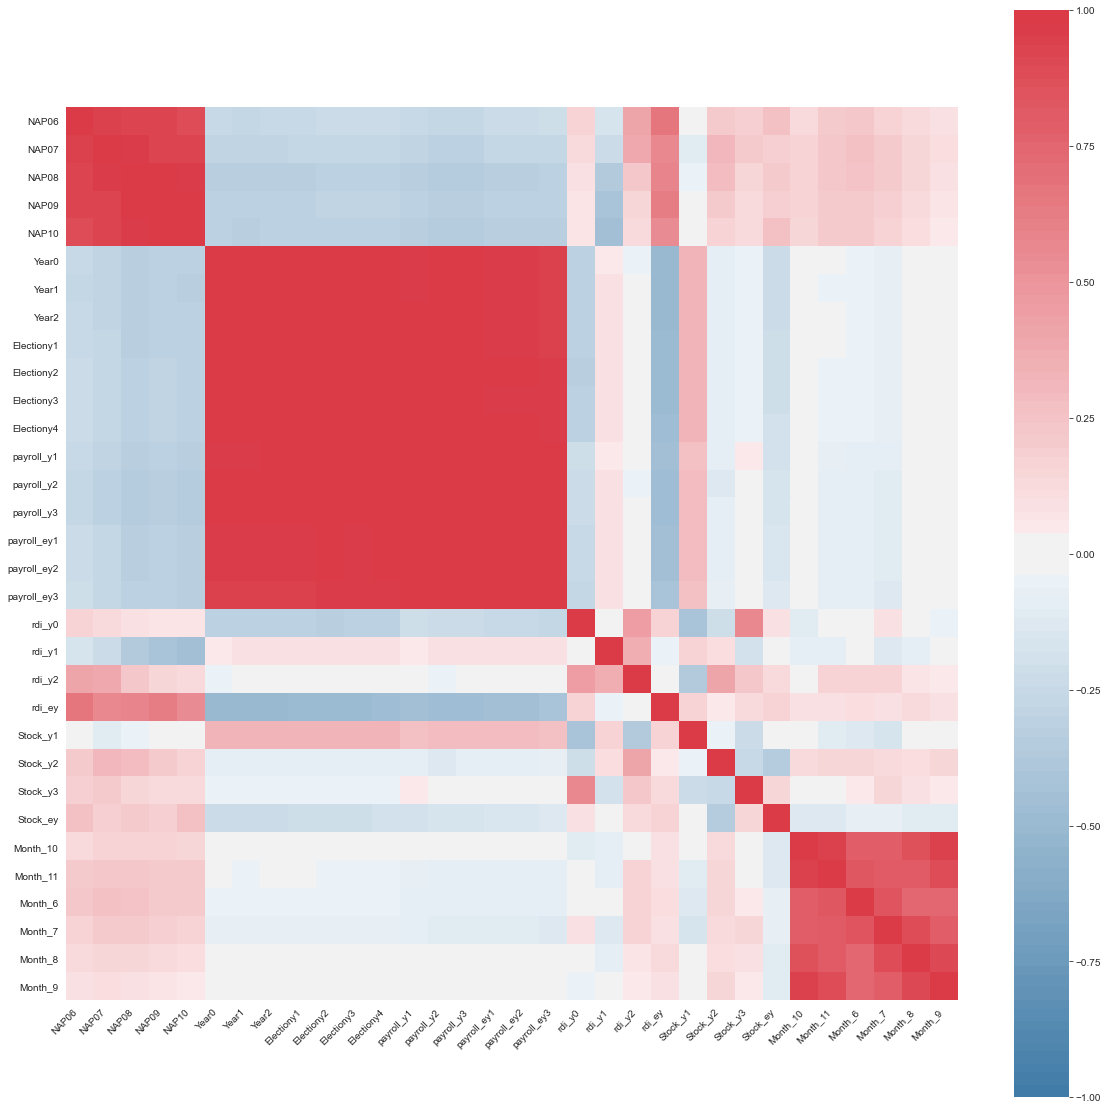

In [35]:
# Feature correlation matrix
df_pair_plot1 = df_final.drop(['popular_vote_percentage', 'Current_President_Seeking_Reelection', 'Early_Stopping_Previous', '2nd_Mandate_Prev_Pres', 'Democrat_Republican'], axis = 1)

correlation_df1 = pd.DataFrame(df_pair_plot1.corr())
fig, ax = plt.subplots(figsize = (20,20))
ax = sns.heatmap(
    correlation_df1, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(240, 10, n=100),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Now we are going to explore the distribution of the variables in the DataFrame. The intent is to look for potential outliers.

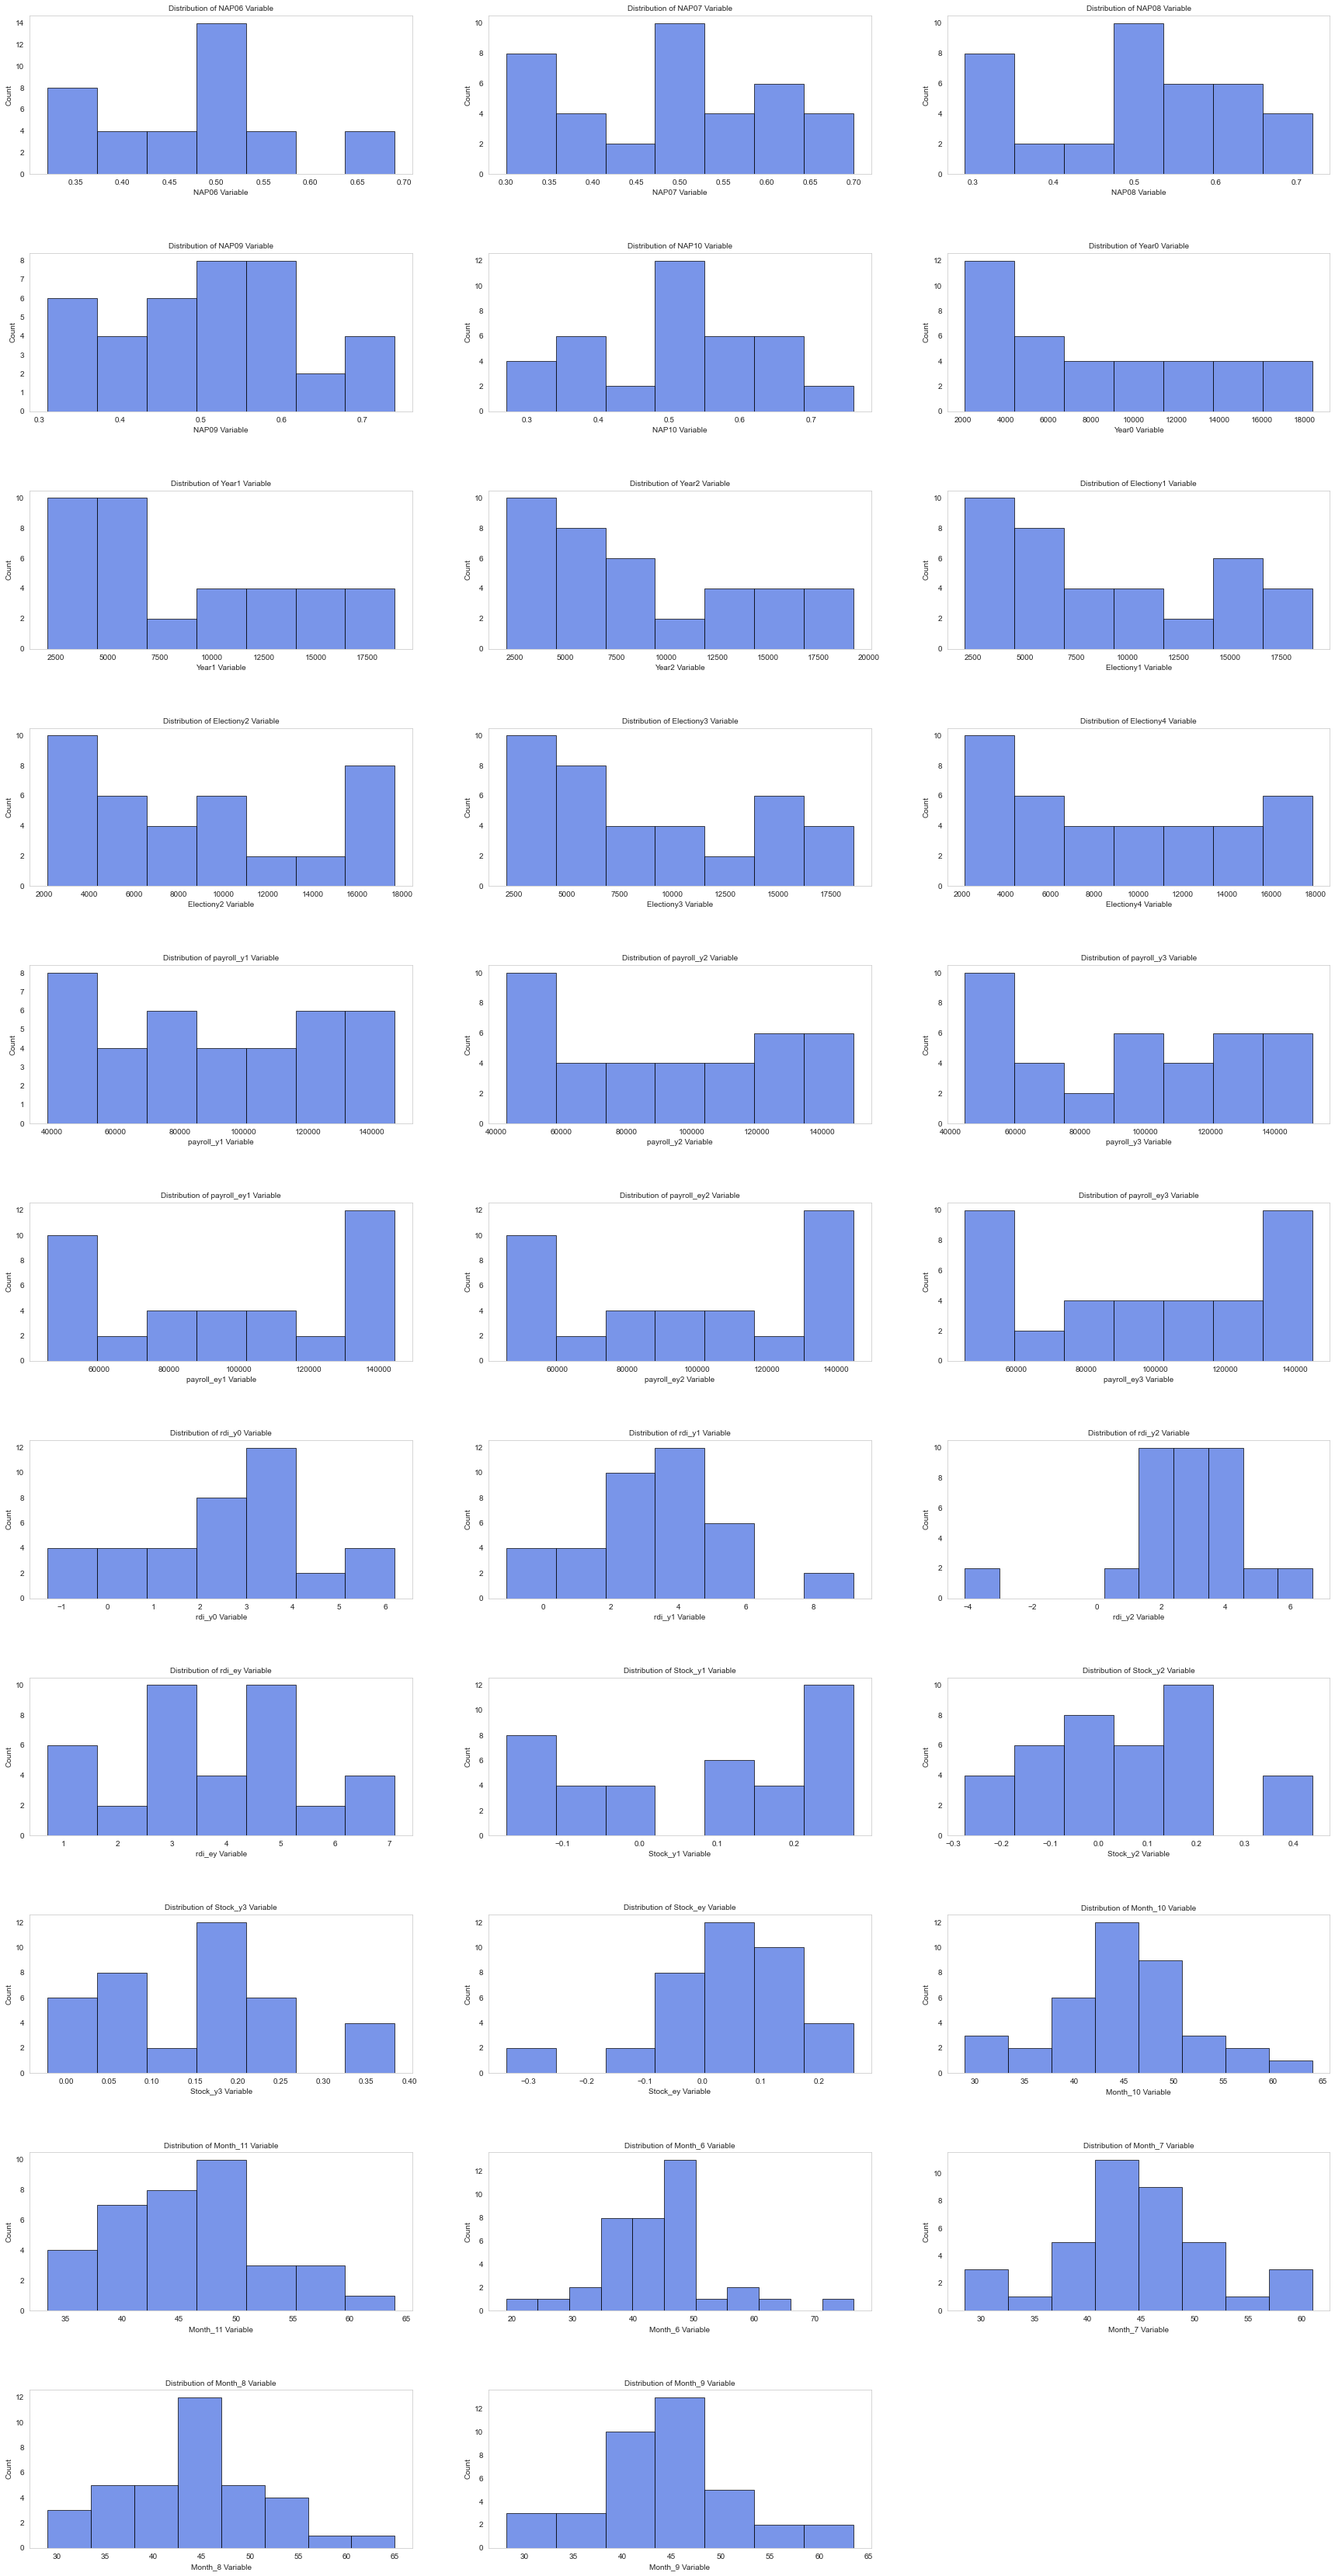

In [36]:
fig, axs = plt.subplots(nrows=11, ncols=3, figsize=(30, 60), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.2)
axs = axs.ravel()
fontsize = 10

variables = df_pair_plot1.columns.values.tolist()
#['NAP', 'payroll', 'stock', 'rdi', 'election', 'national_polls', 'gdp', 'state_election', 'popular_vote_percentage']

# Plot histograms
for i, variable in enumerate(variables):
    axs[i].hist(df_pair_plot1[variable], alpha=0.7, color='royalblue', bins='auto', density=False, histtype = 'bar', edgecolor='k')
    axs[i].set_title("Distribution of " + variable + " Variable", fontsize=fontsize)
    axs[i].set_xlabel(variable + " Variable", fontsize=fontsize)
    axs[i].set_ylabel('Count', fontsize=fontsize)
    
axs[32].set_axis_off()

### 3.2. Bootstrapped LassoCV to Assess Feature Importance

In [37]:
# Splitting into training and testing sets
X = df_final.drop(['popular_vote_percentage'], axis=1)
Y = df_final['popular_vote_percentage']
X_train = X.drop([36,37]).values
y_train = Y.drop([36,37]).values
X_test = X.iloc[[36,37]].values
y_test = Y.iloc[[36,37]].values

In [38]:
# Standardizing the features
X_1 = df_final.drop(['popular_vote_percentage', 'Current_President_Seeking_Reelection', 'Early_Stopping_Previous', '2nd_Mandate_Prev_Pres', 'Democrat_Republican'], axis=1)
X_1.at[2, 'Month_8'] = 52.5
X_1.at[3, 'Month_8'] = 41.75
X_1.at[0, 'Month_11'] = 48
X_1.at[1, 'Month_11'] = 52
scaler = StandardScaler()
scaler.fit(X_1)
x_2 = scaler.transform(X_1)
X_2 = pd.DataFrame(x_2, columns = df_pair_plot1.columns.values.tolist())
X_2['Democrat_Republican'] = df_final['Democrat_Republican']
X_2['Current_President_Seeking_Reelection'] = df_final['Current_President_Seeking_Reelection']
X_2['Early_Stopping_Previous'] = df_final['Early_Stopping_Previous']
X_2['2nd_Mandate_Prev_Pres'] = df_final['2nd_Mandate_Prev_Pres']
X_train1 = X_2.drop([36,37]).values
X_test1 = X_2.iloc[[36,37]].values

In [39]:
X_2_y = X_2.copy()
X_2_y['popular_vote_percentage'] = df_final['popular_vote_percentage']
X_2_y = X_2_y.drop([36,37])

In [40]:
# Function to generate bootstrapped DataFrames
def bootstrap(df):
    selectionIndex = np.random.randint(len(df), size = len(df))
    new_df = df.iloc[selectionIndex]
    return new_df

In [41]:
# Bootstrapped LassoCV
n_bootstraps = 100
coefs = []
intercepts = []
for n in range(n_bootstraps):
    df_new = bootstrap(X_2_y)
    #display(df_new)
    X_train_bootstrap = df_new.drop(['popular_vote_percentage'], axis = 1).values
    y_train_bootstrap = df_new['popular_vote_percentage'].values
    lassoCV = LassoCV(fit_intercept = True, cv = 5).fit(X_train_bootstrap, y_train_bootstrap)
    coefs.append(lassoCV.coef_)
    intercepts.append(lassoCV.intercept_)

In [44]:
# Re-formatting the coefficients lists for plotting 
coef1, coef2, coef3, coef4, coef5, coef6, coef7, coef8, coef9, coef10, coef11, coef12, coef13, coef14, coef15, coef16, coef17, coef18, coef19, coef20, coef21, coef22, coef23, coef24, coef25, coef26, coef27, coef28, coef29, coef30, coef31, coef32, coef33, coef34, coef35, coef36 = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
for coef in coefs:
    if np.abs(float(coef[0])) >= 0.1:
        coef1.append(coef[0])
    else:
        coef1.append(0)
    if np.abs(coef[1]) >= 0.1:
        coef2.append(coef[1])
    else:
        coef2.append(0)
    if np.abs(coef[2]) >= 0.1:
        coef3.append(coef[2])
    else:
        coef3.append(0)
    if np.abs(coef[3]) >= 0.1:
        coef4.append(coef[3])
    else:
        coef4.append(0)
    if np.abs(coef[4]) >= 0.1:
        coef5.append(coef[4])
    else:
        coef5.append(0)
    if np.abs(coef[5]) >= 0.1:
        coef6.append(coef[5])
    else:
        coef6.append(0)
    if np.abs(coef[6]) >= 0.1:
        coef7.append(coef[6])
    else:
        coef7.append(0)
    if np.abs(coef[7]) >= 0.1:
        coef8.append(coef[7])
    else:
        coef8.append(0)
    if np.abs(coef[8]) >= 0.1:
        coef9.append(coef[8])
    else:
        coef9.append(0)
    if np.abs(coef[9]) >= 0.1:
        coef10.append(coef[9])
    else:
        coef10.append(0)
    if np.abs(coef[10]) >= 0.1:
        coef11.append(coef[10])
    else:
        coef11.append(0)
    if np.abs(coef[11]) >= 0.1:
        coef12.append(coef[11])
    else:
        coef12.append(0)
    if np.abs(coef[12]) >= 0.1:
        coef13.append(coef[12])
    else:
        coef13.append(0)
    if np.abs(coef[13]) >= 0.1:
        coef14.append(coef[13])
    else:
        coef14.append(0)
        
    if np.abs(coef[14]) >= 0.1:
        coef15.append(coef[14])
    else:
        coef15.append(0)
    if np.abs(coef[15]) >= 0.1:
        coef16.append(coef[15])
    else:
        coef16.append(0)
    if np.abs(coef[16]) >= 0.1:
        coef17.append(coef[16])
    else:
        coef17.append(0)
    if np.abs(coef[17]) >= 0.1:
        coef18.append(coef[17])
    else:
        coef18.append(0)
    if np.abs(coef[18]) >= 0.1:
        coef19.append(coef[18])
    else:
        coef19.append(0)
    if np.abs(coef[19]) >= 0.1:
        coef20.append(coef[19])
    else:
        coef20.append(0)
    if np.abs(coef[20]) >= 0.1:
        coef21.append(coef[20])
    else:
        coef21.append(0)
    if np.abs(coef[21]) >= 0.1:
        coef22.append(coef[21])
    else:
        coef22.append(0)
    if np.abs(coef[22]) >= 0.1:
        coef23.append(coef[22])
    else:
        coef23.append(0)
    if np.abs(coef[23]) >= 0.1:
        coef24.append(coef[23])
    else:
        coef24.append(0)
        
    if np.abs(coef[24]) >= 0.1:
        coef25.append(coef[24])
    else:
        coef25.append(0)
    if np.abs(coef[25]) >= 0.1:
        coef26.append(coef[25])
    else:
        coef26.append(0)
    if np.abs(coef[26]) >= 0.1:
        coef27.append(coef[26])
    else:
        coef27.append(0)
    if np.abs(coef[27]) >= 0.1:
        coef28.append(coef[27])
    else:
        coef28.append(0)
    if np.abs(coef[28]) >= 0.1:
        coef29.append(coef[28])
    else:
        coef29.append(0)
    if np.abs(coef[29]) >= 0.1:
        coef30.append(coef[29])
    else:
        coef30.append(0)
    if np.abs(coef[30]) >= 0.1:
        coef31.append(coef[30])
    else:
        coef31.append(0)
    if np.abs(coef[31]) >= 0.1:
        coef32.append(coef[31])
    else:
        coef32.append(0)
    if np.abs(coef[32]) >= 0.1:
        coef33.append(coef[32])
    else:
        coef33.append(0)
    if np.abs(coef[33]) >= 0.1:
        coef34.append(coef[33])
    else:
        coef34.append(0)
    if np.abs(coef[34]) >= 0.1:
        coef35.append(coef[34])
    else:
        coef35.append(0)
    if np.abs(coef[35]) >= 0.1:
        coef36.append(coef[35])
    else:
        coef36.append(0)

lst = df_pair_plot1.columns.values.tolist()
lst.append('Democrat_Republican')
lst.append('Current_President_Seeking_Reelection')
lst.append('Early_Stopping_Previous')
lst.append('2nd_Mandate_Prev_Pres')

coefs = pd.DataFrame((coef1,coef2,coef3,coef4,coef5,coef6,coef7,coef8,coef9,coef10,coef11,coef12,coef13,coef14,coef15,coef16,coef17,coef18,coef19,coef20,coef21,coef22,coef23,coef24,coef25,coef26,coef27,coef28,coef29,coef30,coef31,coef32,coef33,coef34,coef35,coef36), index = lst)
coefs = coefs.T

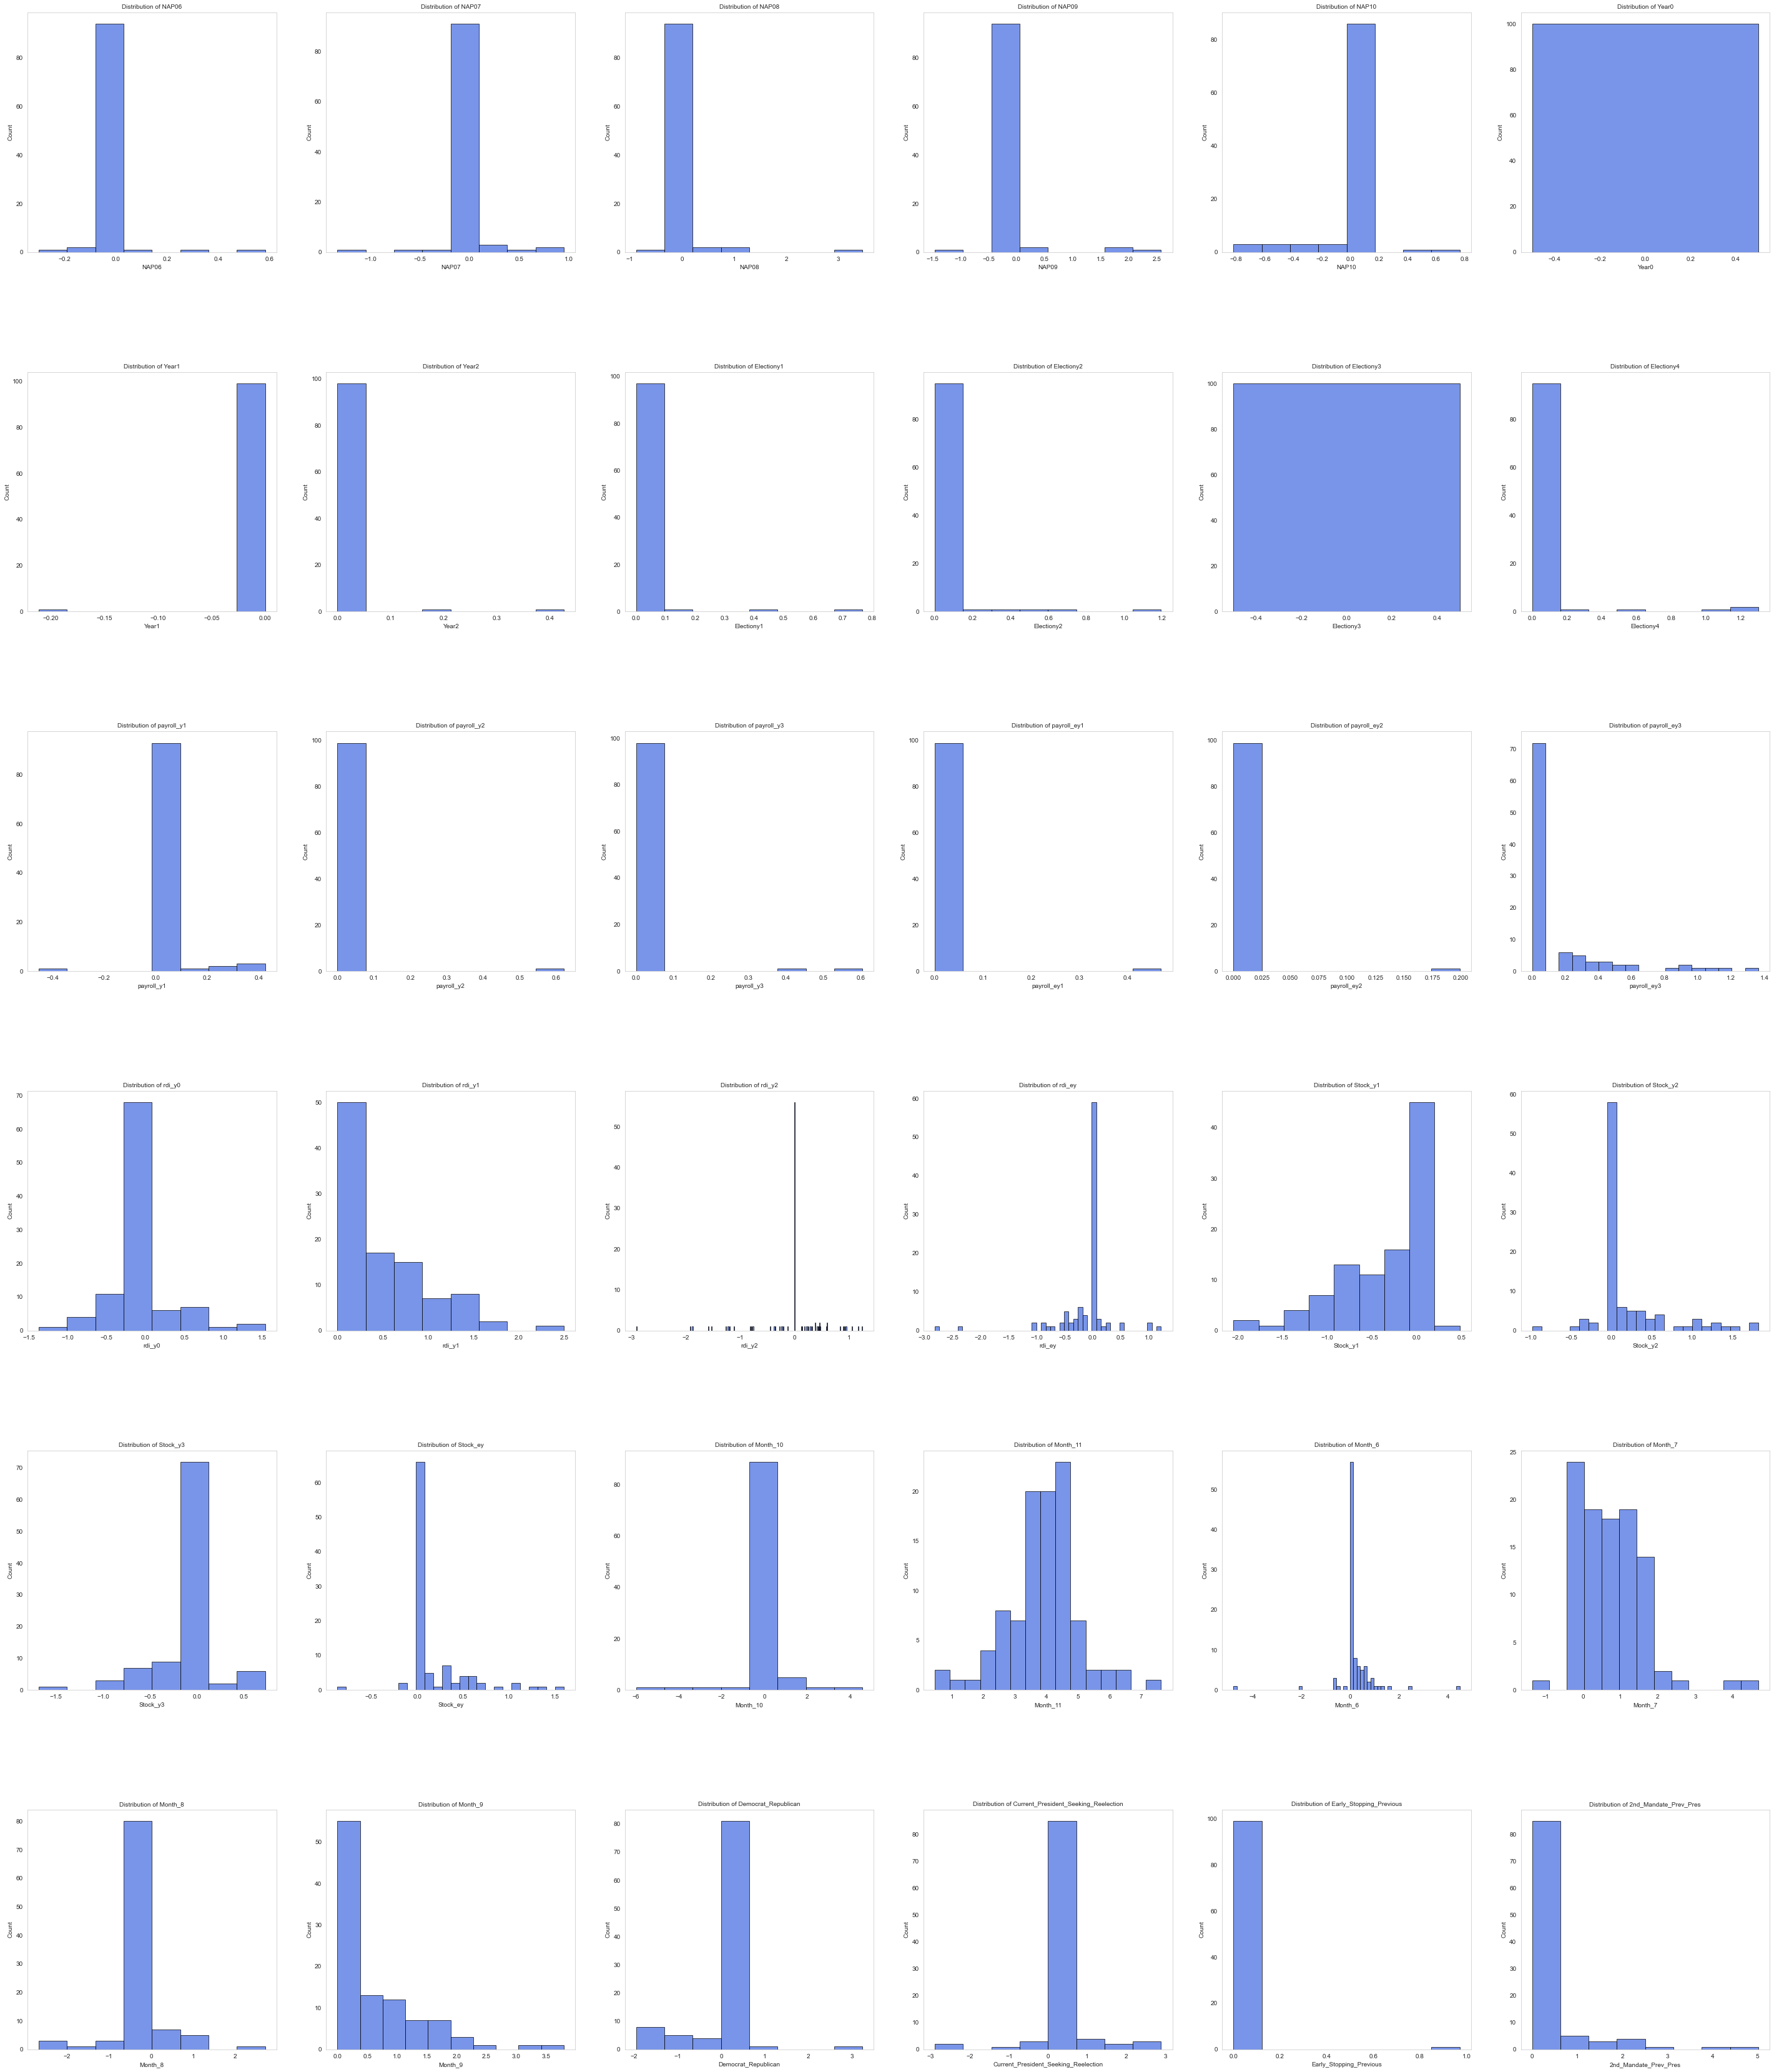

In [45]:
# Plotting histograms from bootstrapped LassoCV feature importance using 
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(50, 60), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.2)
axs = axs.ravel()
fontsize = 10

variables = lst

# plot histograms
for i, variable in enumerate(variables):
    axs[i].hist(coefs[variable], alpha=0.7, color='royalblue', bins='auto', density=False, histtype = 'bar', edgecolor='k')
    axs[i].set_title("Distribution of " + variable, fontsize=fontsize)
    axs[i].set_xlabel(variable, fontsize=fontsize)
    axs[i].set_ylabel('Count', fontsize=fontsize)

In the initial dataset, we observe that in the majority of bootstrapped samples the values of the coefficients were not zeroed. The algorithm only zeroed part of the highly correlated features (the part it picked-up first), improving therefore the adequacy of the dataset to model the 'popular_vote_percentage' by retaining only the most relevant features. As a result after we performed the baseline modeling on the initial dataset, we realized that it is the most adequate dataset for predicting the popular vote. From this point onwards, the modeling part of the popular vote will be based on the initial dataset.

### 3.3. Modeling

In [7]:
df = pd.read_csv('Merged_Fundamentals_and_Polls/merged_df_final.csv', index_col=0)

##### Data Imputation

In [48]:
df.at[2, 'Month_8'] = 52.5
df.at[3, 'Month_8'] = 41.75
df.at[0, 'Month_11'] = 48
df.at[1, 'Month_11'] = 52

In [49]:
display(df.head())

,President_winning,Date,NAP06,NAP07,NAP08,NAP09,NAP10,Current_President_Seeking_Reelection,Early_Stopping_Previous,2nd_Mandate_Prev_Pres,Year0,Year1,Year2,Electiony1,Electiony2,Electiony3,Electiony4,payroll_y1,payroll_y2,payroll_y3,payroll_ey1,payroll_ey2,payroll_ey3,rdi_y0,rdi_y1,rdi_y2,rdi_ey,Stock_y1,Stock_y2,Stock_y3,Stock_ey,Month_10,Month_11,Month_6,Month_7,Month_8,Month_9,Name,Year,Winner,Democrat_Republican,popular_votes,popular_vote_percentage,El_winner
0,Truman,1948,0.48,0.52,0.60,0.65,0.68,0.0,0.0,0.0,2238.932,2068.901,2055.103,2086.017,2120.450,2132.598,2134.981,38600,43093,44411,45178,45294,45245,-1.1,-1.1,-4.1,5.3,0.2665,-0.0814,0.0223,-0.0213,45.000,48.0,38.0,37.0,36.50,39.5,Harry S. Truman,1948,1,1,24179347,49.55,1
1,Truman,1948,0.48,0.52,0.60,0.65,0.68,0.0,0.0,0.0,2238.932,2068.901,2055.103,2086.017,2120.450,2132.598,2134.981,38600,43093,44411,45178,45294,45245,-1.1,-1.1,-4.1,5.3,0.2665,-0.0814,0.0223,-0.0213,50.000,52.0,49.0,48.0,48.50,46.5,Thomas E. Dewey,1948,0,0,21991292,45.07,0
2,Eisenhower,1952,0.33,0.34,0.32,0.31,0.30,0.0,0.0,1.0,2102.251,2383.291,2513.690,2540.550,2546.022,2564.401,2648.621,42942,46706,48006,48924,49320,49597,0.8,9.2,3.4,3.5,0.1288,0.1763,0.1437,0.0842,50.667,49.5,59.0,50.0,52.50,55.0,Dwight D. Eisenhower,1952,1,0,34075529,55.18,1
3,Eisenhower,1952,0.33,0.34,0.32,0.31,0.30,0.0,0.0,1.0,2102.251,2383.291,2513.690,2540.550,2546.022,2564.401,2648.621,42942,46706,48006,48924,49320,49597,0.8,9.2,3.4,3.5,0.1288,0.1763,0.1437,0.0842,39.333,39.5,31.0,43.0,41.75,40.5,Aldai Stevenson II,1952,0,1,27375090,44.33,0
4,Eisenhower,1956,0.68,0.70,0.72,0.74,0.76,1.0,0.0,0.0,2662.482,2735.091,2914.993,2903.671,2927.665,2925.035,2973.179,50240,48942,51429,52631,52604,52777,4.8,1.4,6.7,4.8,-0.0377,0.4396,0.2077,0.0227,51.000,59.0,62.0,61.0,52.00,52.0,Dwight D. Eisenhower,1956,1,0,35579180,57.37,1


##### Train/Test split

In [50]:
X = df.drop(['President_winning', 'Date', 'Early_Stopping_Previous','popular_vote_percentage', 'Winner', 'Name', 'Year', 'El_winner'], axis=1)
Y = df['popular_vote_percentage']
X_train = X.drop([36,37])
y_train = Y.drop([36,37])
X_test = X.iloc[[36,37]]
y_test = Y.iloc[[36,37]]

In [51]:
X_train['state_election'] = 1*X_train['Current_President_Seeking_Reelection'] -1*X_train['2nd_Mandate_Prev_Pres']
X_train.drop(['Current_President_Seeking_Reelection', '2nd_Mandate_Prev_Pres'], axis=1, inplace=True)

In [52]:
X_test['state_election'] = 1*X_test['Current_President_Seeking_Reelection'] -1*X_test['2nd_Mandate_Prev_Pres']
X_test.drop(['Current_President_Seeking_Reelection', '2nd_Mandate_Prev_Pres'], axis=1, inplace=True)

##### Data Standardization

In [53]:
Scaler = StandardScaler().fit(X_train)
X_scaled=Scaler.transform(X_train)
X_test_scaled=Scaler.transform(X_test)

In [54]:
alphas = [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10,100,1000]  # regularization parameters for Lasso

#### Creating the PCA vectors

In [55]:
X_pca = X_scaled
pca = PCA().fit(X_pca)
X_scaled_PCA = pca.transform(X_scaled)
X_test_PCA = pca.transform(X_test_scaled)
print(pca.explained_variance_ratio_)

[4.22986130e-01 1.70564824e-01 1.20893148e-01 6.76652721e-02
 5.50654291e-02 3.83720977e-02 2.90835995e-02 2.64725378e-02
 1.59433006e-02 1.45613548e-02 9.15544193e-03 8.54337012e-03
 6.15969185e-03 5.51733752e-03 3.56155520e-03 2.28558550e-03
 8.40086921e-04 7.99309189e-04 5.64189911e-04 4.69547680e-04
 2.32502938e-04 1.54997859e-04 6.81348536e-05 3.68214796e-05
 3.73322879e-06 5.26562364e-32 2.71693579e-33 2.71693579e-33
 2.71693579e-33 2.71693579e-33 2.71693579e-33 2.71693579e-33
 2.71693579e-33 2.71693579e-33 2.71693579e-33]


#### Linear Regression with Scaled data

In [59]:
scores_lreg = cross_validate(LinearRegression(), X_scaled, y_train, cv=9, scoring='neg_mean_squared_error')
scores_lreg = np.mean(scores_lreg['test_score'])
print(f"Linear regression with scalled data neg_mean_squared_error: {scores_lreg}")

Linear regression with scalled data neg_mean_squared_error: -72.53458439386272


#### Linear Regression with PCA 

In [60]:
scores_lreg_pca = cross_validate(LinearRegression(), X_scaled_PCA[:, :3], y_train, cv=9, scoring='neg_mean_squared_error')
scores_lreg_pca = np.mean(scores_lreg_pca['test_score'])
print(f"Linear regression with PCA neg_mean_squared_error: {scores_lreg_pca}")

Linear regression with PCA neg_mean_squared_error: -7.6117620475178445


In [61]:
for d in range(1, 15):
    Lreg = LinearRegression(fit_intercept=True)
    scores_lreg_pca = cross_validate(Lreg, X_scaled_PCA[:, :d], y_train, cv=9, scoring='neg_mean_squared_error', n_jobs=-1)['test_score']
    scores_lreg_pca = np.mean(scores_lreg_pca)
    print('With depth ', d, scores_lreg_pca)

With depth  1 -37.21100807467282
With depth  2 -18.1415835934954
With depth  3 -7.6117620475178445
With depth  4 -8.063201333572078
With depth  5 -8.667583338288495
With depth  6 -10.070466628848603
With depth  7 -10.631112969872346
With depth  8 -11.913928286218738
With depth  9 -13.101697417265477
With depth  10 -12.200969583813526
With depth  11 -12.644231071412877
With depth  12 -14.030831917981237
With depth  13 -14.865596059654056
With depth  14 -17.831851856242086


#### Lasso Regression with Scaled data

In [62]:
Lasso = LassoCV(alphas=alphas, fit_intercept=True, max_iter=2000)
scores_lasso = cross_validate(Lasso, X_scaled, y_train, cv=9, scoring='neg_mean_squared_error', n_jobs=-1, return_estimator=True)

In [63]:
print(f"Lasso regression with scalled data neg_mean_squared_error: {np.mean(scores_lasso['test_score'])}")

Lasso regression with scalled data neg_mean_squared_error: -13.77076411274527


#### Lasso Regression with PCA

In [64]:
Lasso = LassoCV(alphas=alphas, fit_intercept=True, max_iter=2000)
scores_lasso_pca = cross_validate(Lasso, X_scaled_PCA[:, :5], y_train, cv=9, scoring='neg_mean_squared_error', n_jobs=-1)['test_score']
scores_lasso_pca = np.mean(scores_lasso_pca)
print(f"Lasso regression with PCA neg_mean_squared_error: {scores_lasso_pca}")

Lasso regression with PCA neg_mean_squared_error: -7.587388801669089


In [65]:
for d in range(1, 15):
    Lasso = LassoCV(alphas=alphas, fit_intercept=True, max_iter=2000)
    scores_lasso_pca = cross_validate(Lasso, X_scaled_PCA[:, :d], y_train, cv=9, scoring='neg_mean_squared_error', n_jobs=-1)['test_score']
    scores_lasso_pca = np.mean(scores_lasso_pca)
    print('With depth ', d, scores_lasso_pca)

With depth  1 -36.51729737413194
With depth  2 -17.46005604125999
With depth  3 -7.535059006935303
With depth  4 -7.531279980378675
With depth  5 -7.587388801669089
With depth  6 -7.617977299642714
With depth  7 -7.703972878548697
With depth  8 -7.907577526542151
With depth  9 -7.907577526542151
With depth  10 -9.00995172106973
With depth  11 -9.00995172106973
With depth  12 -9.388934024677262
With depth  13 -9.335732304707975
With depth  14 -9.335732304707975


#### Tree Based Regression with Scaled Data

In [66]:
depths = np.arange(1, 10, 1)
for depth in depths:
    score_tree = cross_validate(DecisionTreeRegressor(max_depth=depth), X_scaled, y_train, cv=9, scoring='neg_mean_squared_error', n_jobs=-1)
    score_tree= np.mean(score_tree['test_score'])
    print('With depth ', depth, score_tree)

With depth  1 -23.639832224878646
With depth  2 -12.336803861148054
With depth  3 -16.086912807415118
With depth  4 -14.87315177584877
With depth  5 -16.3791224537037
With depth  6 -14.822258139660489
With depth  7 -17.394716666666667
With depth  8 -14.060930555555553
With depth  9 -17.938825


#### Tree Based Regression with PCA

In [67]:
depths = np.arange(1, 10, 1)
num_predictors = np.arange(1, 15, 1)
for depth in depths:
    for num_predictor in num_predictors:
        
        score_tree = cross_validate(DecisionTreeRegressor(max_depth=depth), X_scaled_PCA[:,:num_predictor], y_train, cv=9, scoring='neg_mean_squared_error', n_jobs=-1)
        score_tree= np.mean(score_tree['test_score'])
        print('With depth ', depth, 'and PCA components ', num_predictor, score_tree)

With depth  1 and PCA components  1 -37.83347740854002
With depth  1 and PCA components  2 -20.367520058502212
With depth  1 and PCA components  3 -20.367520058502205
With depth  1 and PCA components  4 -20.36752005850221
With depth  1 and PCA components  5 -20.36752005850221
With depth  1 and PCA components  6 -20.367520058502194
With depth  1 and PCA components  7 -20.367520058502205
With depth  1 and PCA components  8 -20.367520058502215
With depth  1 and PCA components  9 -20.367520058502212
With depth  1 and PCA components  10 -20.36752005850221
With depth  1 and PCA components  11 -20.3675200585022
With depth  1 and PCA components  12 -20.367520058502205
With depth  1 and PCA components  13 -20.36752005850223
With depth  1 and PCA components  14 -20.367520058502212
With depth  2 and PCA components  1 -43.49494251200682
With depth  2 and PCA components  2 -21.800727202419694
With depth  2 and PCA components  3 -23.90704078266661
With depth  2 and PCA components  4 -24.333474115999

#### Random Forest Regression

##### On initial Data

In [68]:
# Number of trees in random forest
n_estimators_over = [50, 90, 110, 150, 200]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth_over = [int(x) for x in np.linspace(1, 8, num=5)]
# Minimum number of samples required to split a node
min_samples_split = [1, 2, 3]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 4, 5]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators_over,
               'max_features': max_features,
               'max_depth': max_depth_over,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,

               }
# Use the random grid to search for best hyperparameters

rf = RandomForestRegressor()
random_model = GridSearchCV(estimator=rf, param_grid=random_grid, verbose=1,
                                    scoring='neg_mean_squared_error',
                                    n_jobs=-1, return_train_score=True, cv=2, refit=True)
random_model.fit(X_scaled, y_train)
dict_rf = cross_validate(RandomForestRegressor(**random_model.best_params_), X_scaled, y_train, cv=9, scoring='neg_mean_squared_error')
rf_initial_mse = np.mean(dict_rf['test_score'])

Fitting 2 folds for each of 900 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 1785 out of 1800 | elapsed:   51.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:   52.0s finished


In [70]:
print(f"Random Forrest regression with initial data neg_mean_squared_error: {rf_initial_mse}")

Random Forrest regression with initial data neg_mean_squared_error: -8.684520723163219


##### On PCA data

In [71]:
# Number of trees in random forest
n_estimators_over = [10, 30, 50, 90]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth_over = [int(x) for x in np.linspace(1, 8, num=5)]
# Minimum number of samples required to split a node
min_samples_split = [1, 2, 3]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 4, 5]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators_over,
               'max_features': max_features,
               'max_depth': max_depth_over,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,

               }
# Use the random grid to search for best hyperparameters

rf = RandomForestRegressor()
random_model = GridSearchCV(estimator=rf, param_grid=random_grid, verbose=1,
                                    scoring='neg_mean_squared_error',
                                    n_jobs=-1, return_train_score=True, cv=2, refit=True)
depths = np.arange(1, 15, 1)
for depth in depths:
    random_model.fit(X_scaled_PCA[:, :d], y_train)
    dict_rf = cross_validate(RandomForestRegressor(**random_model.best_params_), X_scaled_PCA[:, :d], y_train, cv=9, scoring='neg_mean_squared_error', n_jobs=-1)
    rf_pca_mse = np.mean(dict_rf['test_score'])
    print('With components ', depth, 'the CV score is ', rf_pca_mse)

Fitting 2 folds for each of 720 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   15.9s finished


With components  1 the CV score is  -17.945884933706537
Fitting 2 folds for each of 720 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 1425 out of 1440 | elapsed:   15.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   15.5s finished


With components  2 the CV score is  -16.393940943670557
Fitting 2 folds for each of 720 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 1425 out of 1440 | elapsed:   14.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   14.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


With components  3 the CV score is  -17.89102288069452
Fitting 2 folds for each of 720 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 1425 out of 1440 | elapsed:   16.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   16.7s finished


With components  4 the CV score is  -16.436418634931428
Fitting 2 folds for each of 720 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   15.3s finished


With components  5 the CV score is  -17.078455069260492
Fitting 2 folds for each of 720 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1425 out of 1440 | elapsed:   14.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   14.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


With components  6 the CV score is  -19.065967140044247
Fitting 2 folds for each of 720 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 1425 out of 1440 | elapsed:   15.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   15.6s finished


With components  7 the CV score is  -17.497828897741787
Fitting 2 folds for each of 720 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   14.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


With components  8 the CV score is  -17.954096550225184
Fitting 2 folds for each of 720 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 1425 out of 1440 | elapsed:   16.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   16.4s finished


With components  9 the CV score is  -15.79303305940078
Fitting 2 folds for each of 720 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 1425 out of 1440 | elapsed:   17.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   17.7s finished


With components  10 the CV score is  -17.887880516175503
Fitting 2 folds for each of 720 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   17.0s finished


With components  11 the CV score is  -16.897690721293934
Fitting 2 folds for each of 720 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   15.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


With components  12 the CV score is  -17.996636878729415
Fitting 2 folds for each of 720 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 1425 out of 1440 | elapsed:   15.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   15.9s finished


With components  13 the CV score is  -17.786692639978465
Fitting 2 folds for each of 720 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    8.4s


With components  14 the CV score is  -17.98314523685552


[Parallel(n_jobs=-1)]: Done 1425 out of 1440 | elapsed:   16.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   16.5s finished


#### Boosting Regression

##### On scaled data

In [72]:
depths = np.linspace(1,10,10)

# Base Estimator
#base_estimator = [DecisionTreeRegressor(max_depth = depth) for depth in depths]
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
# Learning Rate
learning_rate = [1e-3,1e-2,1e-1,1,10]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate}
scores = []
params_scaled = []
for depth in depths:
    # Create a based model
    ada = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = depth))
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = ada, param_grid = param_grid, cv = 2, n_jobs = -1, verbose = 2, scoring = 'neg_mean_squared_error')
    grid_search.fit(X_scaled, y_train)
    dict_boosting = cross_validate(AdaBoostRegressor(**grid_search.best_params_), X_scaled, y_train, cv=9, scoring='neg_mean_squared_error', n_jobs=-1)
    boosting_mse = np.mean(dict_boosting['test_score'])
    print('With components ', depth, 'the CV score is ', boosting_mse)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


With components  1.0 the CV score is  -11.122953294522711
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


With components  2.0 the CV score is  -9.005836143073608
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


With components  3.0 the CV score is  -10.081399531894377
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished


With components  4.0 the CV score is  -10.9676293553241
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.1s finished


With components  5.0 the CV score is  -8.73449411009392
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.0s finished


With components  6.0 the CV score is  -9.915283870149487
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished


With components  7.0 the CV score is  -9.786694602928044
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.1s finished


With components  8.0 the CV score is  -9.918327756409635
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished


With components  9.0 the CV score is  -9.042978827998677
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished


With components  10.0 the CV score is  -10.496160004396547


##### With PCA

In [73]:
depths = np.linspace(1,10,10)
num_components = np.arange(1, 15, 1)
# Base Estimator
#base_estimator = [DecisionTreeRegressor(max_depth = depth) for depth in depths]
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
# Learning Rate
learning_rate = [1e-3, 1e-2, 1e-1, 1, 10]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate}
scores = []
params= []
for num_component in num_components:
    for depth in depths:
        # Create a based model
        ada = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = depth))
        # Instantiate the grid search model
        grid_search = GridSearchCV(estimator = ada, param_grid = param_grid, cv = 2, n_jobs = -1, verbose = 2, scoring = 'neg_mean_squared_error')
        grid_search.fit(X_scaled, y_train)
        dict_boosting = cross_validate(AdaBoostRegressor(**grid_search.best_params_), X_scaled_PCA[:, :num_component], y_train, cv=9, scoring='neg_mean_squared_error', n_jobs=-1)
        boosting_mse = np.mean(dict_boosting['test_score'])
        print('With components ', depth, 'the CV score is ', boosting_mse, 'and with a number of PC ', num_component)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


With components  1.0 the CV score is  -49.333720443656645 and with a number of PC  1
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished


With components  2.0 the CV score is  -40.81481345846978 and with a number of PC  1
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.5s finished


With components  3.0 the CV score is  -43.1239214917669 and with a number of PC  1
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


With components  4.0 the CV score is  -41.08948433443503 and with a number of PC  1
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.6s finished


With components  5.0 the CV score is  -38.134504463875984 and with a number of PC  1
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.5s finished


With components  6.0 the CV score is  -39.20047708876625 and with a number of PC  1
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s finished


With components  7.0 the CV score is  -40.453970263102626 and with a number of PC  1
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s finished


With components  8.0 the CV score is  -39.144915619059034 and with a number of PC  1
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.2s finished


With components  9.0 the CV score is  -40.694795791458375 and with a number of PC  1
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.3s finished


With components  10.0 the CV score is  -40.51256889995281 and with a number of PC  1
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished


With components  1.0 the CV score is  -24.29025935425535 and with a number of PC  2
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.7s finished


With components  2.0 the CV score is  -24.75829804335424 and with a number of PC  2
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s finished


With components  3.0 the CV score is  -28.588692824859574 and with a number of PC  2
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.5s finished


With components  4.0 the CV score is  -30.04262627646406 and with a number of PC  2
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s finished


With components  5.0 the CV score is  -21.4296187158429 and with a number of PC  2
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished


With components  6.0 the CV score is  -28.74066081148176 and with a number of PC  2
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


With components  7.0 the CV score is  -33.460284748160056 and with a number of PC  2
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.8s finished


With components  8.0 the CV score is  -22.55148278464224 and with a number of PC  2
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.5s finished


With components  9.0 the CV score is  -26.05595488361523 and with a number of PC  2
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.6s finished


With components  10.0 the CV score is  -22.042568642550393 and with a number of PC  2
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished


With components  1.0 the CV score is  -11.898265576267228 and with a number of PC  3
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.0s finished


With components  2.0 the CV score is  -11.292226932016822 and with a number of PC  3
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


With components  3.0 the CV score is  -14.47362221477496 and with a number of PC  3
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished


With components  4.0 the CV score is  -10.838235027881764 and with a number of PC  3
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


With components  5.0 the CV score is  -10.554338433710939 and with a number of PC  3
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.5s finished


With components  6.0 the CV score is  -12.57883973018776 and with a number of PC  3
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.6s finished


With components  7.0 the CV score is  -11.515897042776638 and with a number of PC  3
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished


With components  8.0 the CV score is  -12.243405876027655 and with a number of PC  3
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished


With components  9.0 the CV score is  -12.136569739254988 and with a number of PC  3
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished


With components  10.0 the CV score is  -11.483482682777659 and with a number of PC  3
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


With components  1.0 the CV score is  -12.8658094474885 and with a number of PC  4
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


With components  2.0 the CV score is  -13.73708057559186 and with a number of PC  4
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.7s finished


With components  3.0 the CV score is  -12.127846269239184 and with a number of PC  4
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


With components  4.0 the CV score is  -12.742364075163463 and with a number of PC  4
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished


With components  5.0 the CV score is  -13.184911924863108 and with a number of PC  4
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


With components  6.0 the CV score is  -13.894578851357368 and with a number of PC  4
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.6s finished


With components  7.0 the CV score is  -14.391576051333864 and with a number of PC  4
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished


With components  8.0 the CV score is  -13.849322762718312 and with a number of PC  4
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished


With components  9.0 the CV score is  -14.254512041665208 and with a number of PC  4
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished


With components  10.0 the CV score is  -13.025305568581281 and with a number of PC  4
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished


With components  1.0 the CV score is  -13.713519716674064 and with a number of PC  5
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


With components  2.0 the CV score is  -13.499568558549104 and with a number of PC  5
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.7s finished


With components  3.0 the CV score is  -13.544955772551928 and with a number of PC  5
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.8s finished


With components  4.0 the CV score is  -13.73154521427829 and with a number of PC  5
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished


With components  5.0 the CV score is  -13.505238598472982 and with a number of PC  5
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


With components  6.0 the CV score is  -16.703431813563753 and with a number of PC  5
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished


With components  7.0 the CV score is  -14.083897105910202 and with a number of PC  5
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished


With components  8.0 the CV score is  -14.570401976142335 and with a number of PC  5
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.3s finished


With components  9.0 the CV score is  -13.850619249016495 and with a number of PC  5
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished


With components  10.0 the CV score is  -13.059789644588019 and with a number of PC  5
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished


With components  1.0 the CV score is  -13.654636519287079 and with a number of PC  6
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished


With components  2.0 the CV score is  -13.586690054821737 and with a number of PC  6
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.0s finished


With components  3.0 the CV score is  -13.57287709586716 and with a number of PC  6
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished


With components  4.0 the CV score is  -13.456023493890545 and with a number of PC  6
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished


With components  5.0 the CV score is  -13.313463350686003 and with a number of PC  6
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.4s finished


With components  6.0 the CV score is  -14.272333032619192 and with a number of PC  6
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.2s finished


With components  7.0 the CV score is  -14.175312460908712 and with a number of PC  6
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished


With components  8.0 the CV score is  -14.11094411893477 and with a number of PC  6
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.3s finished


With components  9.0 the CV score is  -12.072066484998457 and with a number of PC  6
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    5.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.5s finished


With components  10.0 the CV score is  -15.152691436994493 and with a number of PC  6
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


With components  1.0 the CV score is  -15.32154834353798 and with a number of PC  7
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.5s finished


With components  2.0 the CV score is  -13.796562447005162 and with a number of PC  7
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.2s finished


With components  3.0 the CV score is  -14.221342461742056 and with a number of PC  7
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished


With components  4.0 the CV score is  -14.323152136392151 and with a number of PC  7
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished


With components  5.0 the CV score is  -14.13793847003606 and with a number of PC  7
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    5.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.2s finished


With components  6.0 the CV score is  -13.892895837092821 and with a number of PC  7
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.4s finished


With components  7.0 the CV score is  -14.419899953167747 and with a number of PC  7
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished


With components  8.0 the CV score is  -14.241214961657164 and with a number of PC  7
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    5.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.6s finished


With components  9.0 the CV score is  -14.243953257961481 and with a number of PC  7
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished


With components  10.0 the CV score is  -14.788341327613336 and with a number of PC  7
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished


With components  1.0 the CV score is  -15.955442070606365 and with a number of PC  8
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.2s finished


With components  2.0 the CV score is  -14.903118388325687 and with a number of PC  8
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.4s finished


With components  3.0 the CV score is  -14.611213463250746 and with a number of PC  8
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.2s finished


With components  4.0 the CV score is  -13.91411003513689 and with a number of PC  8
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.8s finished


With components  5.0 the CV score is  -15.101075288299711 and with a number of PC  8
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.4s finished


With components  6.0 the CV score is  -14.185767132228074 and with a number of PC  8
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.2s finished


With components  7.0 the CV score is  -13.492024417103018 and with a number of PC  8
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished


With components  8.0 the CV score is  -13.665004463479793 and with a number of PC  8
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished


With components  9.0 the CV score is  -13.79391190954855 and with a number of PC  8
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.5s finished


With components  10.0 the CV score is  -14.04221348881626 and with a number of PC  8
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


With components  1.0 the CV score is  -16.244257645532134 and with a number of PC  9
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.8s finished


With components  2.0 the CV score is  -14.716618209667566 and with a number of PC  9
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.2s finished


With components  3.0 the CV score is  -14.916204098560463 and with a number of PC  9
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    5.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.9s finished


With components  4.0 the CV score is  -16.633857961131817 and with a number of PC  9
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.5s finished


With components  5.0 the CV score is  -17.572941970402173 and with a number of PC  9
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.5s finished


With components  6.0 the CV score is  -16.515295774207864 and with a number of PC  9
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.6s finished


With components  7.0 the CV score is  -16.030756719311942 and with a number of PC  9
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.4s finished


With components  8.0 the CV score is  -15.772084723539807 and with a number of PC  9
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished


With components  9.0 the CV score is  -14.440075476210312 and with a number of PC  9
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.2s finished


With components  10.0 the CV score is  -15.019687122222921 and with a number of PC  9
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished


With components  1.0 the CV score is  -18.615807335836273 and with a number of PC  10
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished


With components  2.0 the CV score is  -15.296903753432069 and with a number of PC  10
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.2s finished


With components  3.0 the CV score is  -16.847354189885632 and with a number of PC  10
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.1s finished


With components  4.0 the CV score is  -15.622658260020152 and with a number of PC  10
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished


With components  5.0 the CV score is  -16.372625585207356 and with a number of PC  10
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    5.9s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.2s finished


With components  6.0 the CV score is  -18.764022429578354 and with a number of PC  10
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished


With components  7.0 the CV score is  -16.00550111783647 and with a number of PC  10
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.5s finished


With components  8.0 the CV score is  -16.97212147105263 and with a number of PC  10
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished


With components  9.0 the CV score is  -16.09401504530635 and with a number of PC  10
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.5s finished


With components  10.0 the CV score is  -16.16186482942938 and with a number of PC  10
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished


With components  1.0 the CV score is  -16.177388150709213 and with a number of PC  11
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.8s finished


With components  2.0 the CV score is  -15.324654907757669 and with a number of PC  11
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.2s finished


With components  3.0 the CV score is  -15.135205588491232 and with a number of PC  11
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished


With components  4.0 the CV score is  -16.186591905132392 and with a number of PC  11
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.4s finished


With components  5.0 the CV score is  -16.019127675752216 and with a number of PC  11
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.2s finished


With components  6.0 the CV score is  -14.704505768827776 and with a number of PC  11
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.2s finished


With components  7.0 the CV score is  -14.716938123441833 and with a number of PC  11
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished


With components  8.0 the CV score is  -15.327007132869944 and with a number of PC  11
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished


With components  9.0 the CV score is  -17.845102230572966 and with a number of PC  11
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished


With components  10.0 the CV score is  -17.430617542971067 and with a number of PC  11
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished


With components  1.0 the CV score is  -17.151372588551766 and with a number of PC  12
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.2s finished


With components  2.0 the CV score is  -18.606331163335245 and with a number of PC  12
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.2s finished


With components  3.0 the CV score is  -17.413037895970366 and with a number of PC  12
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.6s finished


With components  4.0 the CV score is  -18.341444590695698 and with a number of PC  12
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.4s finished


With components  5.0 the CV score is  -14.840869911557368 and with a number of PC  12
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished


With components  6.0 the CV score is  -17.29571119941693 and with a number of PC  12
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.2s finished


With components  7.0 the CV score is  -17.252886557705086 and with a number of PC  12
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.5s finished


With components  8.0 the CV score is  -14.928513335174065 and with a number of PC  12
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.6s finished


With components  9.0 the CV score is  -16.104075080380618 and with a number of PC  12
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.3s finished


With components  10.0 the CV score is  -16.180830320388793 and with a number of PC  12
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


With components  1.0 the CV score is  -18.43786321097337 and with a number of PC  13
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.2s finished


With components  2.0 the CV score is  -15.903983688160626 and with a number of PC  13
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.9s finished


With components  3.0 the CV score is  -17.064572926975256 and with a number of PC  13
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.5s finished


With components  4.0 the CV score is  -16.195354342787912 and with a number of PC  13
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


With components  5.0 the CV score is  -18.901091229551266 and with a number of PC  13
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.2s finished


With components  6.0 the CV score is  -17.023879135214834 and with a number of PC  13
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished


With components  7.0 the CV score is  -17.26421712502312 and with a number of PC  13
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished


With components  8.0 the CV score is  -16.109592370738056 and with a number of PC  13
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.4s finished


With components  9.0 the CV score is  -15.50440395766172 and with a number of PC  13
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.4s finished


With components  10.0 the CV score is  -16.447185497421433 and with a number of PC  13
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished


With components  1.0 the CV score is  -16.06091254818442 and with a number of PC  14
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.1s finished


With components  2.0 the CV score is  -16.75582837256395 and with a number of PC  14
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.2s finished


With components  3.0 the CV score is  -16.76610135486464 and with a number of PC  14
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished


With components  4.0 the CV score is  -17.945489233117307 and with a number of PC  14
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.4s finished


With components  5.0 the CV score is  -16.110952478166457 and with a number of PC  14
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.4s finished


With components  6.0 the CV score is  -14.618075406940408 and with a number of PC  14
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.2s finished


With components  7.0 the CV score is  -15.717332407939445 and with a number of PC  14
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished


With components  8.0 the CV score is  -16.199198563003733 and with a number of PC  14
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished


With components  9.0 the CV score is  -15.32851344338953 and with a number of PC  14
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished


With components  10.0 the CV score is  -16.104651674165005 and with a number of PC  14


In [74]:
models=['Lreg', 'Lreg 3 PCA', 'Lasso', 'Lasso 3 PCA', 'Tree depth 2', 'Tree depth 5 4 PCA', 'RF', 'RF PCA', 'Boosting depth 6', 'Boosting 3 PCA stumps']
scores = [-72.53458439386266, -7.6117620475178525, -13.77076411274527, -7.587388801669093, -12.686170397255966, -14.307216176957562, -9.929047643788575, -15.864297791035066, -8.594188453895246, -10.723440359661234]
models_scoring = pd.DataFrame({'Models': models, 'Neg CV MSE, cv=9': scores})
models_scoring

,Models,"Neg CV MSE, cv=9"
0,Lreg,-72.534584
1,Lreg 3 PCA,-7.611762
2,Lasso,-13.770764
3,Lasso 3 PCA,-7.587389
4,Tree depth 2,-12.686170
5,Tree depth 5 4 PCA,-14.307216
6,RF,-9.929048
7,RF PCA,-15.864298
8,Boosting depth 6,-8.594188
9,Boosting 3 PCA stumps,-10.723440


### 3.4. Final EDA on Results

##### Explained Variance

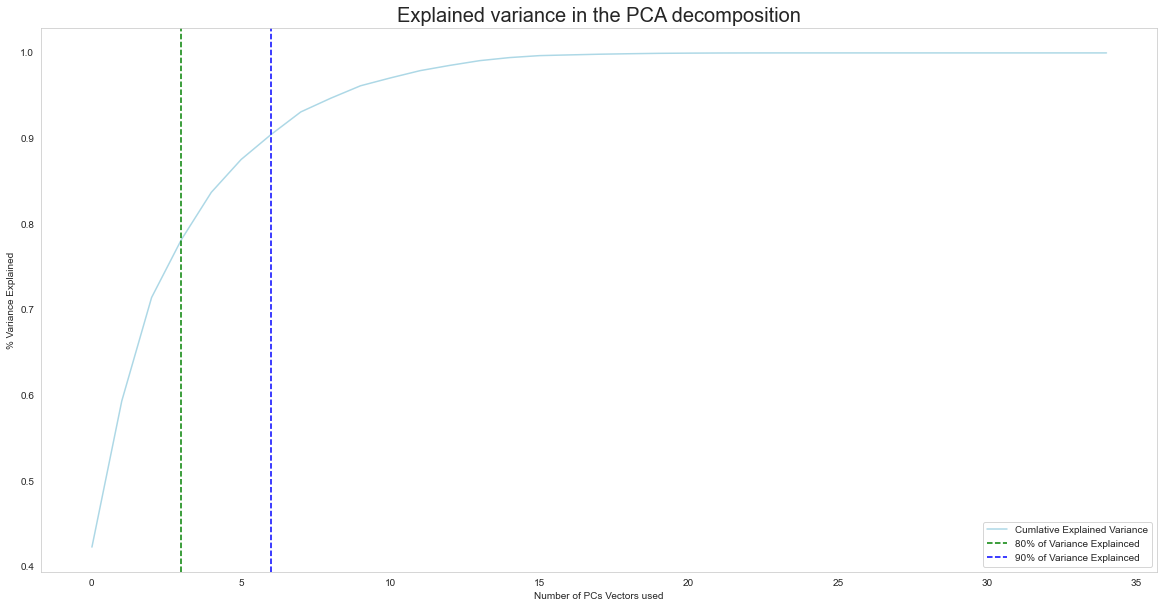

In [75]:
variance_explained_pca = pca.explained_variance_ratio_
fig, ax = plt.subplots(1, figsize=(20, 10))
ax.plot(np.cumsum(variance_explained_pca), color='lightblue', label='Cumlative Explained Variance')
ax.set_title('Explained variance in the PCA decomposition', size=20)
ax.set_xlabel('Number of PCs Vectors used')
ax.set_ylabel('% Variance Explained')
ax.grid(False)
ax.axvline(x=3, label='80% of Variance Explainced', color='green', linestyle='--')
ax.axvline(x=6, label='90% of Variance Explainced', color='blue', linestyle='--')
ax.legend()
plt.show(fig)

##### Visualization of the 3 PCs

In [76]:
X_vis = X_scaled_PCA[:, :3]

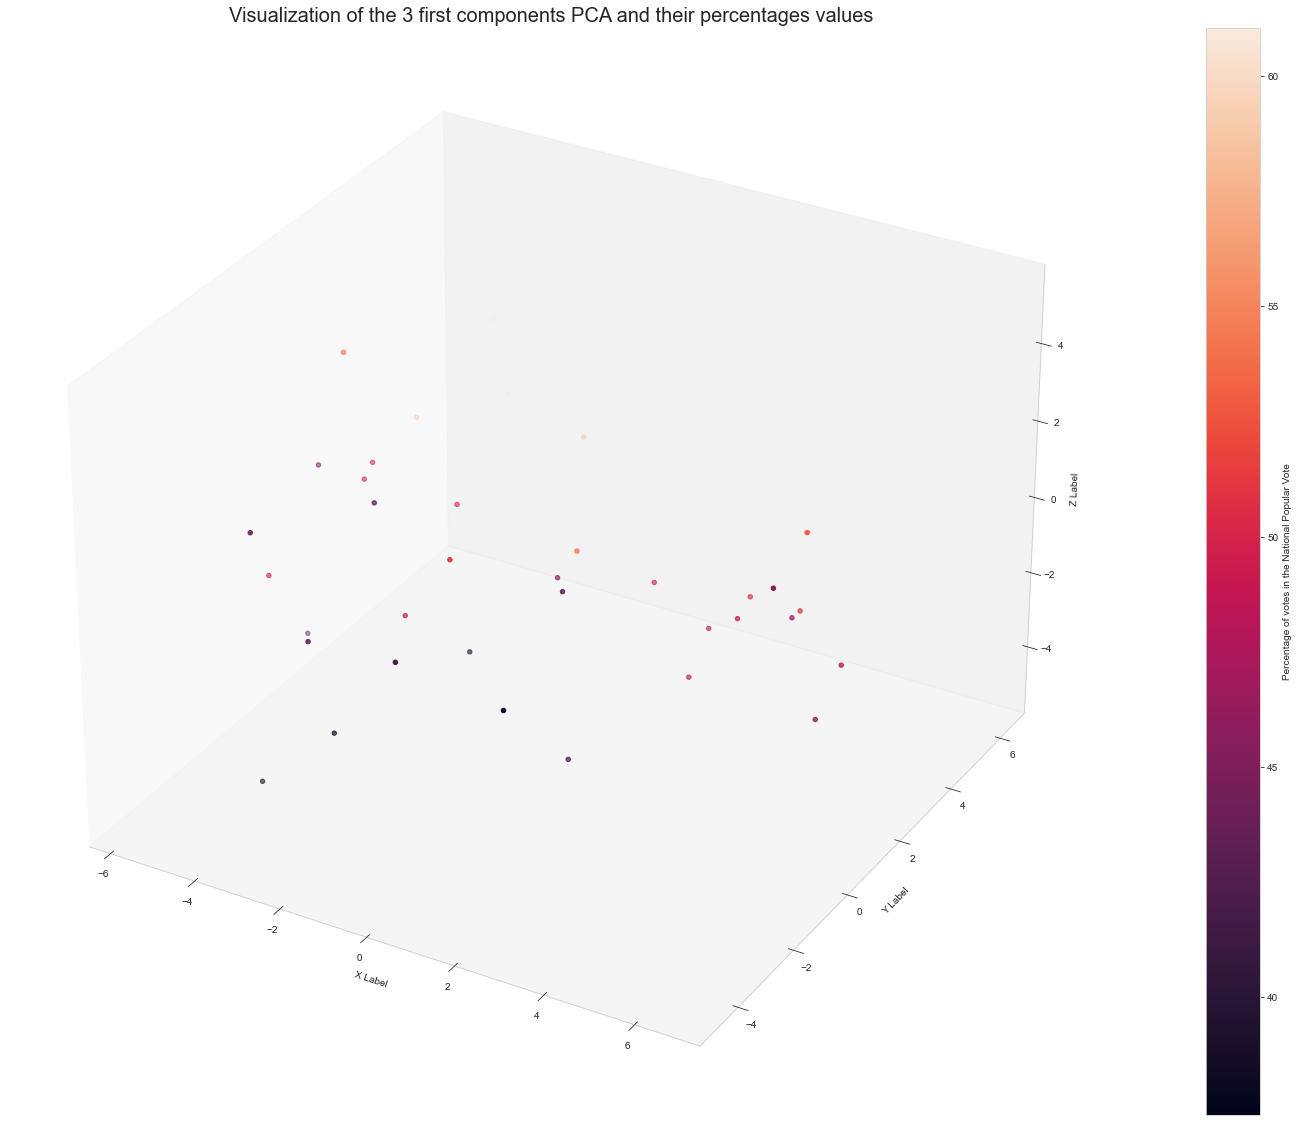

In [77]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import


fig = plt.figure(figsize = (40, 20))
ax = fig.add_subplot(111, projection='3d')
surface = ax.scatter(X_vis[:, 0], X_vis[:, 1], X_vis[:, 2], c=y_train)
fig.colorbar(surface, label='Percentage of votes in the National Popular Vote')
ax.grid(False)
ax.set_title('Visualization of the 3 first components PCA and their percentages values', size=20)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()